In [1]:
import numpy as np
import glob, os
from nilearn import image, plotting, masking
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.spatial import distance
from collections import Counter
from itertools import chain, compress
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import RidgeClassifier
from nilearn import image,plotting
import numpy as np
import pandas as pd
import glob, os, itertools
from brainiak.image import mask_images, multimask_images
from brainiak import io
from brainiak.fcma.preprocessing import prepare_mvpa_data
from brainiak.fcma.preprocessing import generate_epochs_info
from scipy.stats import pearsonr,ttest_1samp, rankdata, ttest_rel
from scipy.stats.mstats import zscore
from sklearn.svm import SVC
import seaborn as sns
import subprocess
import re 
from statsmodels.stats.anova import AnovaRM

/packages/miniconda/20190102/envs/anaconda-tensorflow-gpu/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/peetal/.local/lib/python3.6/site-packages/nilearn/plotting/cm.py:159: MatplotlibDeprecationWarning: 
The revcmap function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use Colormap.reversed() instead.
  _cmaps_data[_cmapname_r] = _cm.revcmap(_cmapspec)
/packages/miniconda/20190102/envs/anaconda-tensorflow-gpu/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at 

## load and stack permutation and real data

In [6]:
# -----------------
# permutation data
# -----------------
# permutation dat directory
permutate_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result/FCMA_permutation/perScramble_ret_permutation/'
# permutation data (100 iteration)
permutate_dat = sorted(glob.glob(os.path.join(permutate_dir, '*score.nii.gz')))
# stack all 100 iterations into a 4d data
permutate_dat_4d = np.stack([image.load_img(dat).get_fdata() for dat in permutate_dat], axis = 3)
# -----------------
# real data
# -----------------
# real dat directory
real_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result/FCMA/sb_gm_mask/'
# 24 inner loop data 
inner_cv_dat = sorted(glob.glob(os.path.join(real_dir, '*score.nii.gz')))
# stack all 24 iterations into a 4d data
inner_cv_dat_4d = np.stack([image.load_img(dat).get_fdata() for dat in inner_cv_dat], axis = 3)

# mask out data into (tr, voxel)
mask = image.load_img('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/all_sub_universal_GM_mask.nii.gz')
permutate_dat_4d_nii = image.new_img_like(mask, permutate_dat_4d, mask.affine)
permutate_dat_4d_mask = masking.apply_mask(permutate_dat_4d_nii, mask)
inner_cv_dat_4d_nii = image.new_img_like(mask, inner_cv_dat_4d, mask.affine)
inner_cv_dat_4d_mask = masking.apply_mask(inner_cv_dat_4d_nii, mask)

In [9]:
permutate_dat_4d_mask.shape

(100, 92745)

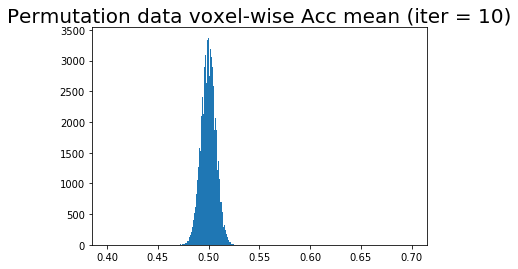

In [11]:
plt.title("Permutation data voxel-wise Acc mean (iter = 10)", fontsize=20)
_ = plt.hist(np.mean(permutate_dat_4d_mask[0:10,:], axis = 0), bins = 500, range=[0.4, 0.7])

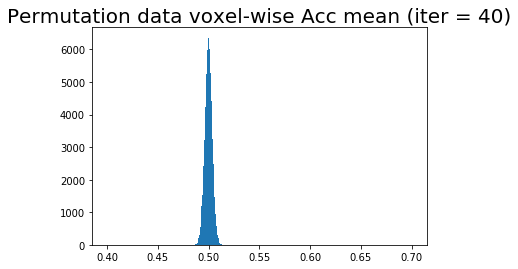

In [16]:
plt.title("Permutation data voxel-wise Acc mean (iter = 40)", fontsize=20)
_ = plt.hist(np.mean(permutate_dat_4d_mask[0:40,:], axis = 0), bins = 500, range=[0.4, 0.7])

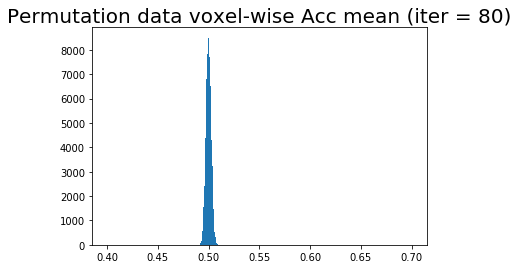

In [17]:
plt.title("Permutation data voxel-wise Acc mean (iter = 80)", fontsize=20)
_ = plt.hist(np.mean(permutate_dat_4d_mask[0:80,:], axis = 0), bins = 500, range=[0.4, 0.7])

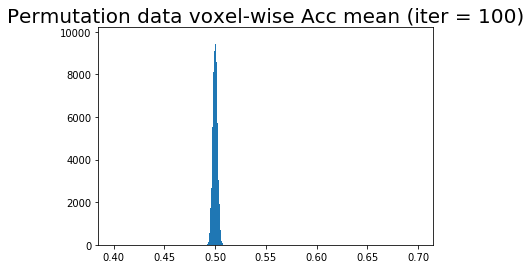

In [18]:
plt.title("Permutation data voxel-wise Acc mean (iter = 100)", fontsize=20)
_ = plt.hist(np.mean(permutate_dat_4d_mask[0:100,:], axis = 0), bins = 500, range=[0.4, 0.7])

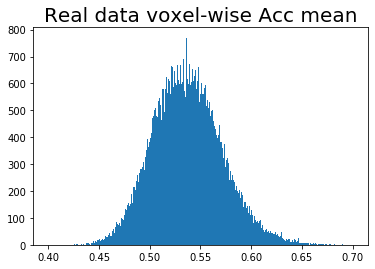

In [68]:
plt.title("Real data voxel-wise Acc mean", fontsize=20)
_ = plt.hist(np.mean(inner_cv_dat_4d_mask, axis = 0), bins = 500, range=[0.4, 0.7])

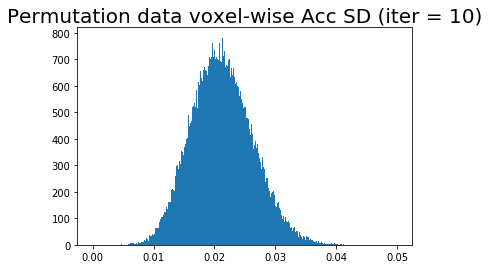

In [21]:
plt.title("Permutation data voxel-wise Acc SD (iter = 10)", fontsize=20)
_ = plt.hist(np.std(permutate_dat_4d_mask[0:10,:], axis = 0), bins = 500, range=[0, 0.05])

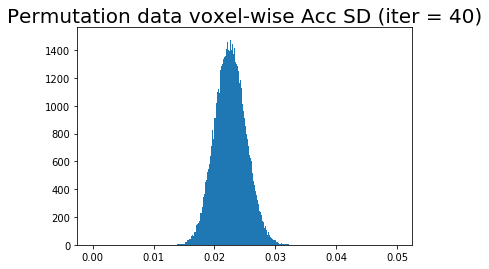

In [22]:
plt.title("Permutation data voxel-wise Acc SD (iter = 40)", fontsize=20)
_ = plt.hist(np.std(permutate_dat_4d_mask[0:40,:], axis = 0), bins = 500, range=[0, 0.05])

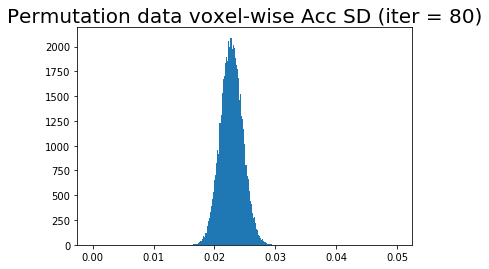

In [23]:
plt.title("Permutation data voxel-wise Acc SD (iter = 80)", fontsize=20)
_ = plt.hist(np.std(permutate_dat_4d_mask[0:80,:], axis = 0), bins = 500, range=[0, 0.05])

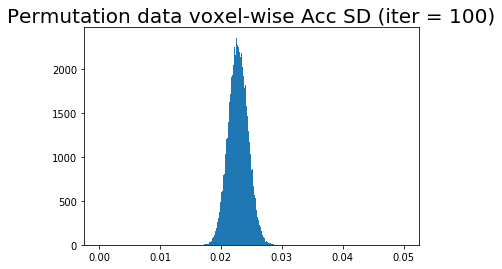

In [24]:
plt.title("Permutation data voxel-wise Acc SD (iter = 100)", fontsize=20)
_ = plt.hist(np.std(permutate_dat_4d_mask[0:100,:], axis = 0), bins = 500, range=[0, 0.05])

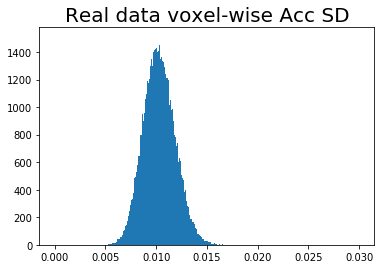

In [70]:
plt.title("Real data voxel-wise Acc SD", fontsize=20)
_ = plt.hist(np.std(inner_cv_dat_4d_mask, axis = 0), bins = 500, range=[0, 0.03])

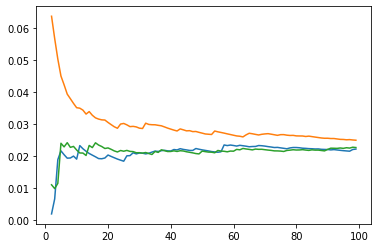

In [67]:
# example voxel 
for voxel in [3000,3500,4000]:
    example_v = permutate_dat_4d_mask[:,voxel]
    sd = []
    mean = []
    for i in list(range(2,example_v.shape[0])):
        sd.append(np.std(example_v[0:i,], axis = 0))
        mean.append(np.mean(example_v[0:i,], axis = 0))

    plt.plot(list(range(2,100)), sd)

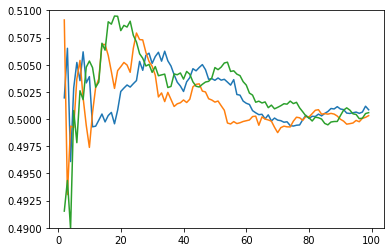

In [69]:
# example voxel 
for voxel in [3000,3500,4000]:
    example_v = permutate_dat_4d_mask[:,voxel]
    sd = []
    mean = []
    for i in list(range(2,example_v.shape[0])):
        mean.append(np.mean(example_v[0:i,], axis = 0))
    
    plt.ylim((0.49, 0.51))
    plt.plot(list(range(2,100)), mean)

In [95]:
# -----------------
# permutation data
# -----------------
# permutation dat directory
permutate_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result/FCMA_permutation/ret_per_permutation/'
# permutation data (100 iteration)
permutate_dat = sorted(glob.glob(os.path.join(permutate_dir, '*score.nii.gz')))
# stack all 100 iterations into a 4d data
permutate_dat_4d = np.stack([image.load_img(dat).get_fdata() for dat in permutate_dat], axis = 3)
permutate_dat_4d_nii = image.new_img_like(mask, permutate_dat_4d, mask.affine)
permutate_dat_4d_mask = masking.apply_mask(permutate_dat_4d_nii, mask)

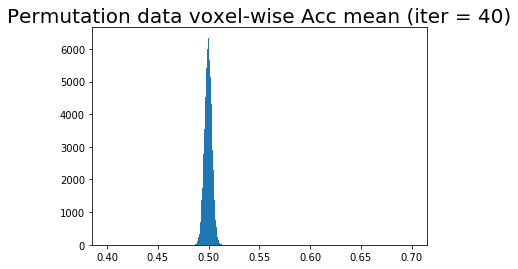

In [82]:
plt.title("Permutation data voxel-wise Acc mean (iter = 40)", fontsize=20)
_ = plt.hist(np.mean(permutate_dat_4d_mask[0:40,:], axis = 0), bins = 500, range=[0.4, 0.7])

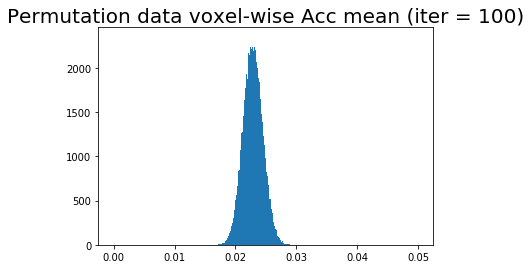

In [83]:
plt.title("Permutation data voxel-wise Acc mean (iter = 100)", fontsize=20)
_ = plt.hist(np.std(permutate_dat_4d_mask[0:100,:], axis = 0), bins = 500, range=[0, 0.05])

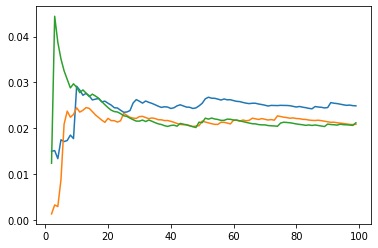

In [86]:
# example voxel 
for voxel in [5000,5500,6000]:
    example_v = permutate_dat_4d_mask[:,voxel]
    sd = []
    mean = []
    for i in list(range(2,example_v.shape[0])):
        sd.append(np.std(example_v[0:i,], axis = 0))
        mean.append(np.mean(example_v[0:i,], axis = 0))

    plt.plot(list(range(2,100)), sd)

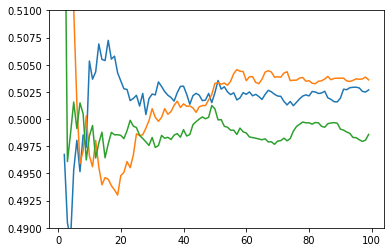

In [87]:
# example voxel 
for voxel in [5000,5500,6000]:
    example_v = permutate_dat_4d_mask[:,voxel]
    sd = []
    mean = []
    for i in list(range(2,example_v.shape[0])):
        mean.append(np.mean(example_v[0:i,], axis = 0))
    
    plt.ylim((0.49, 0.51))
    plt.plot(list(range(2,100)), mean)

In [120]:
# -----------------
# permutation data
# -----------------
permutate_dat_4d = image.load_img('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/ret_per_scramble_composite_information_mapping/composite_mean/permutate_dat_4d.nii.gz').get_fdata()
permutate_dat_4d_nii = image.new_img_like(mask, permutate_dat_4d, mask.affine)
permutate_dat_4d_mask = masking.apply_mask(permutate_dat_4d_nii, mask)

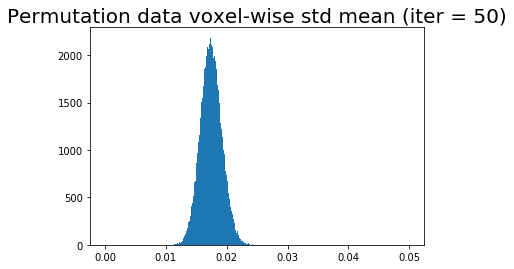

In [130]:
plt.title("Permutation data voxel-wise std mean (iter = 50)", fontsize=20)
_ = plt.hist(np.std(permutate_dat_4d_mask[0:50,:], axis = 0), bins = 500, range=[0, 0.05])

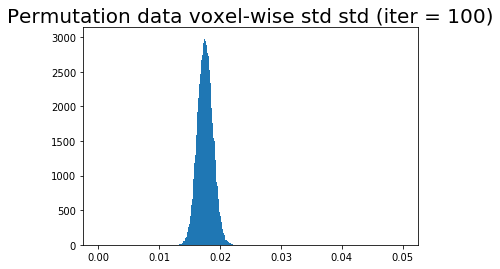

In [132]:
plt.title("Permutation data voxel-wise std std (iter = 100)", fontsize=20)
_ = plt.hist(np.std(permutate_dat_4d_mask[0:100,:], axis = 0), bins = 500, range=[0, 0.05])

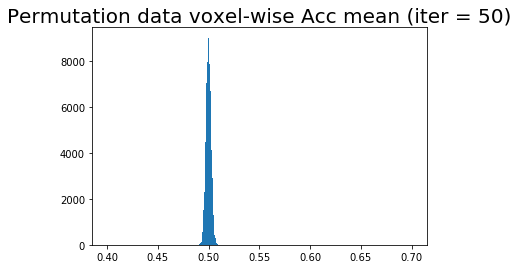

In [128]:
plt.title("Permutation data voxel-wise Acc mean (iter = 50)", fontsize=20)
_ = plt.hist(np.mean(permutate_dat_4d_mask[0:50,:], axis = 0), bins = 500, range=[0.4, 0.7])

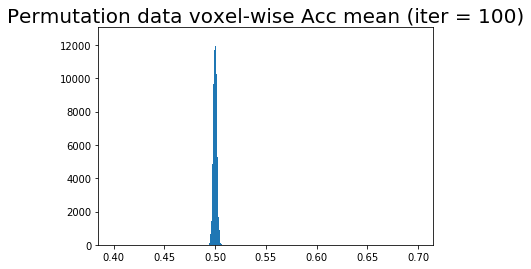

In [125]:
plt.title("Permutation data voxel-wise Acc mean (iter = 100)", fontsize=20)
_ = plt.hist(np.mean(permutate_dat_4d_mask[0:100,:], axis = 0), bins = 500, range=[0.4, 0.7])

In [ ]:
plt.title("Permutation data voxel-wise Acc mean (iter = 100)", fontsize=20)
_ = plt.hist(np.mean(permutate_dat_4d_mask[0:100,:], axis = 0), bins = 500, range=[0.4, 0.7])

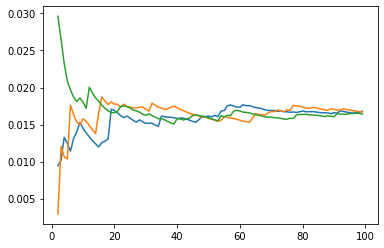

In [126]:
# example voxel 
for voxel in [5000,5500,6000]:
    example_v = permutate_dat_4d_mask[:,voxel]
    sd = []
    mean = []
    for i in list(range(2,example_v.shape[0])):
        sd.append(np.std(example_v[0:i,], axis = 0))
        mean.append(np.mean(example_v[0:i,], axis = 0))

    plt.plot(list(range(2,100)), sd)

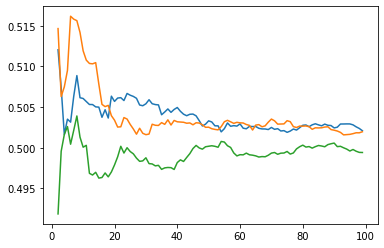

In [129]:
# example voxel 
for voxel in [5000,5500,6000]:
    example_v = permutate_dat_4d_mask[:,voxel]
    sd = []
    mean = []
    for i in list(range(2,example_v.shape[0])):
        sd.append(np.std(example_v[0:i,], axis = 0))
        mean.append(np.mean(example_v[0:i,], axis = 0))

    plt.plot(list(range(2,100)), mean)

## Z score observed data using mean and std from the null distribution

In [54]:
# averaged acc for each voxel
inner_cv_dat_mean = np.mean(inner_cv_dat_4d, axis = 3)
# mean and sd for each voxel for null distribution
permutate_dat_mean = np.mean(permutate_dat_4d, axis = 3)
permutate_dat_sd = np.std(permutate_dat_4d, axis = 3)

# z score observed data
inner_cv_dat_zscore = (inner_cv_dat_mean - permutate_dat_mean)/permutate_dat_sd
inner_cv_dat_zscore = np.nan_to_num(inner_cv_dat_zscore)

# save it out
ref = image.load_img('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/all_sub_universal_GM_mask.nii.gz')
inner_cv_dat_zscore_nii = image.new_img_like(ref, inner_cv_dat_zscore, ref.affine)
#inner_cv_dat_zscore_nii.to_filename('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/information_mapping_001.nii.gz')

/packages/miniconda/20190102/envs/anaconda-tensorflow-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


## Z score each voxel for null distribution of AFNI 3dClustSim

In [73]:
# -----------------
# permutation data
# -----------------
# permutation dat directory
permutate_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result/FCMA_permutation/'
# permutation data (100 iteration)
permutate_dat = sorted(glob.glob(os.path.join(permutate_dir, '*score.nii.gz')))
# stack all 100 iterations into a 4d data
permutate_dat_4d = np.stack([image.load_img(dat).get_fdata() for dat in permutate_dat], axis = 0)

permutate_dat_mean = np.mean(permutate_dat_4d, axis = 0)
permutate_dat_std = np.std(permutate_dat_4d, axis = 0)
permutate_dat_4d_zscore = (permutate_dat_4d - permutate_dat_mean)/permutate_dat_std
permutate_dat_4d_zscore = np.nan_to_num(permutate_dat_4d_zscore)

permutate_dat_4d_zscore_reshape = np.stack([permutate_dat_4d_zscore[i,:,:,:] for i in range(permutate_dat_4d_zscore.shape[0])], axis = 3)
ref = image.load_img('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/all_sub_universal_GM_mask.nii.gz')
permutate_dat_4d_zscore_reshape_nii = image.new_img_like(ref, permutate_dat_4d_zscore_reshape, ref.affine)
permutate_dat_4d_zscore_reshape_nii.to_filename('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/permutate_dat_4d_zscore.nii.gz')

/packages/miniconda/20190102/envs/anaconda-tensorflow-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


## Importance value mapping

In [74]:
# -----------------------------------
# Preprocessing for task-evoked data
# -----------------------------------

# Evoked_response directory
evoked_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/evoked_response/'
evoked_images = io.load_images_from_dir(evoked_dir, suffix='CONCAT.nii.gz')

# FCMA identified top_3000 roi clusters
roi_masks_boo = io.load_boolean_mask('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/cluster_mask231.nii.gz')

# a list of 24 subjects, a 2d array (nvoxel in the mask, 1956 tr)
evoked_ts = list(mask_images(evoked_images, roi_masks_boo, np.float32))

# ---------------------
# save the evoked_ts_np
# ---------------------

mask_npy = np.stack(evoked_ts, axis = 0)
# np.save('/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/ret_per_infomap001_dat_SubVoxTR_fullts.npy', mask_npy)

In [3]:
def _prepare_mvpa_data(roi_activity_data, epoch_file, epochs_per_subj):
    
    epoch_list = io.load_labels(epoch_file_task)
    epoch_info = generate_epochs_info(epoch_list)
    
    num_epochs = len(epoch_info)
    (d1, _) = roi_activity_data[0].shape # number of voxels in this roi
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0] # 1 or 0, perceive or retrieve
        cur_sid = epoch[1]
        processed_data[:, idx] = np.mean(roi_activity_data[cur_sid][:, epoch[2]:epoch[3]], axis = 1)
    
    for i in range(24):
        start_epoch = i*epochs_per_subj
        end_epoch = start_epoch + epochs_per_subj
        processed_data[:, start_epoch:end_epoch] = \
                zscore(processed_data[:, start_epoch:end_epoch],
                       axis=1, ddof=0)
    processed_data = np.nan_to_num(processed_data)
    
    return processed_data, labels

# activity data numpy arrays 
activity_mat = np.load('/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/ret_per_infomap001_dat_SubVoxTR_fullts.npy')
epoch_file_task = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/faceCue_sceneCue_epoch_lables.npy'

# preprocess the data into [voxel, epoch]
processed_data, labels = _prepare_mvpa_data(activity_mat, epoch_file_task, 32)
processed_data_list = [processed_data[:,i] for i in range(len(labels))]

#### train and fit the model

In [99]:
# tune hyperparameter
clf = RidgeClassifierCV(alphas = [3000, 5000, 7000, 8000], cv = 24).fit(processed_data_list,labels)
clf.alpha_

# fit whole training set using the hyperparameter
clf = RidgeClassifier(alpha = 60000).fit(processed_data_list,labels)
clf.score(processed_data_list,labels)

# write nifti file for the importance value map
mask = image.load_img('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/cluster_mask231.nii.gz')
importance_stats_map = masking.unmask(clf.coef_, mask)


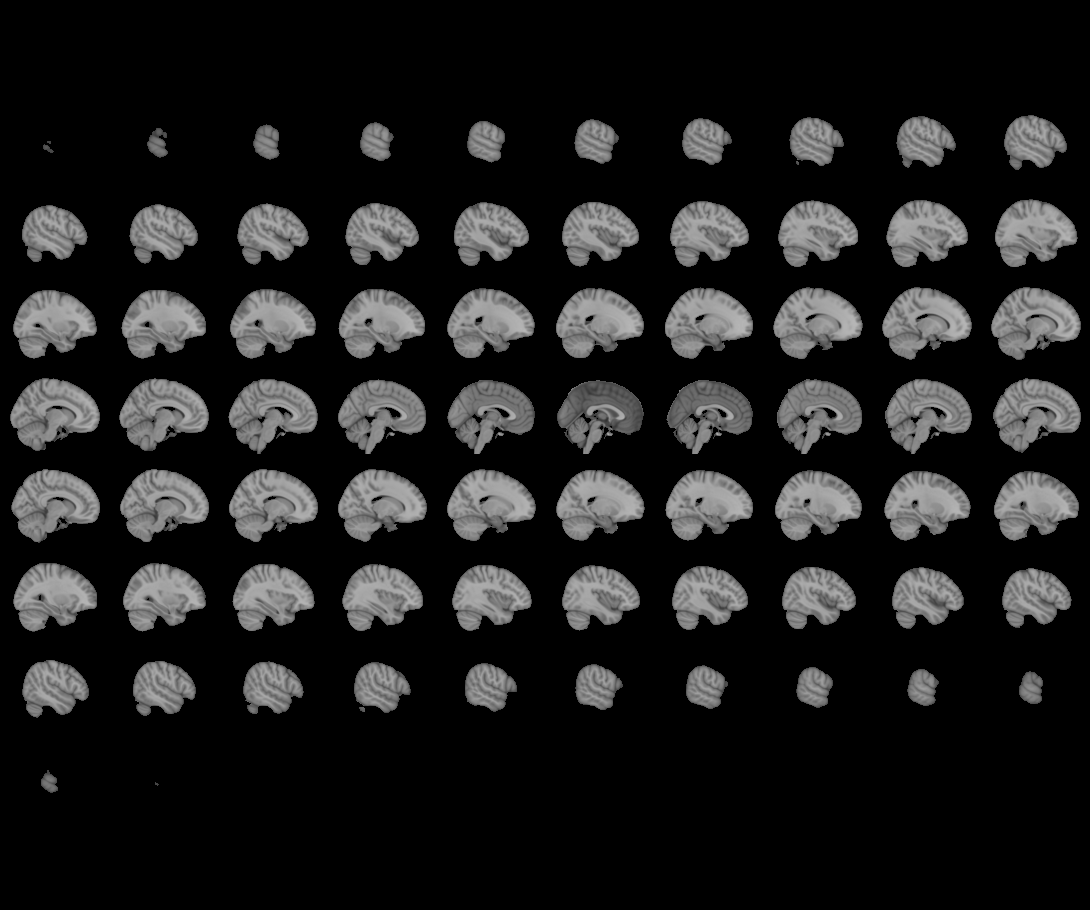
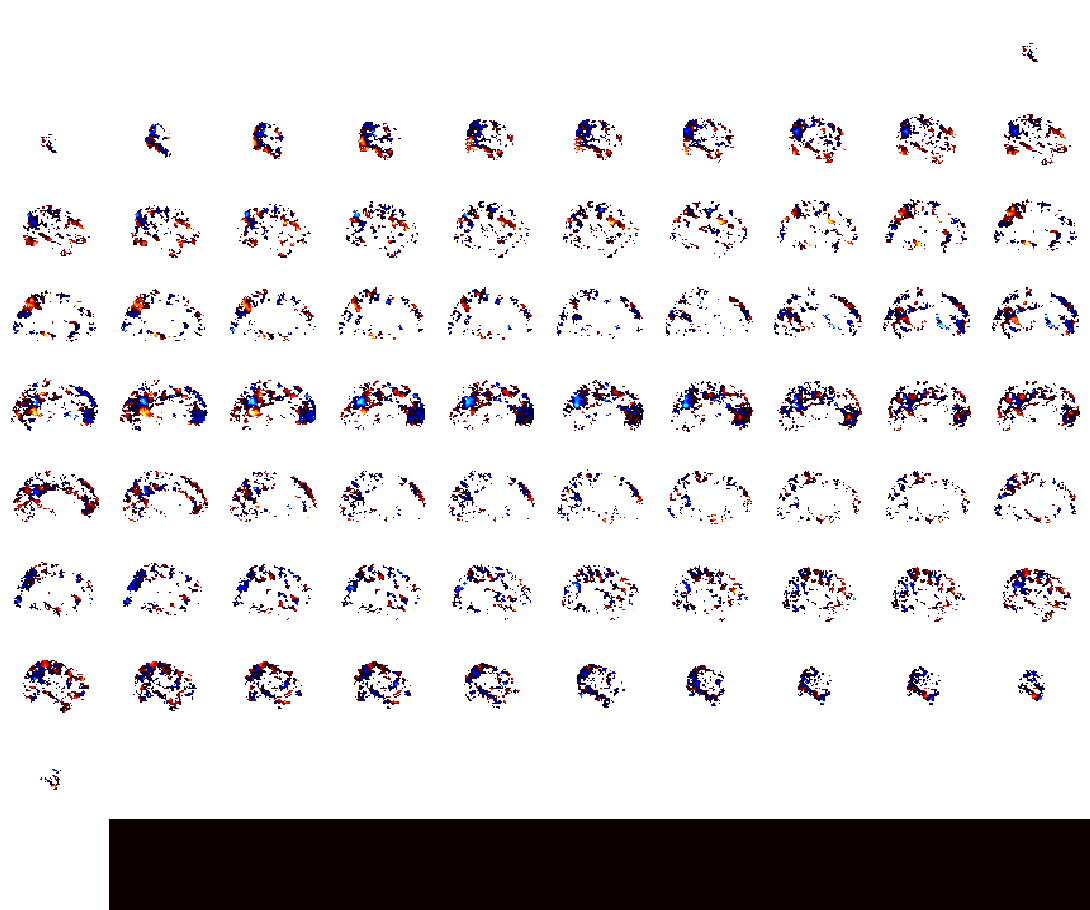

In [67]:
# task state
# alpha = 60000
plotting.view_img(task_stats_map)


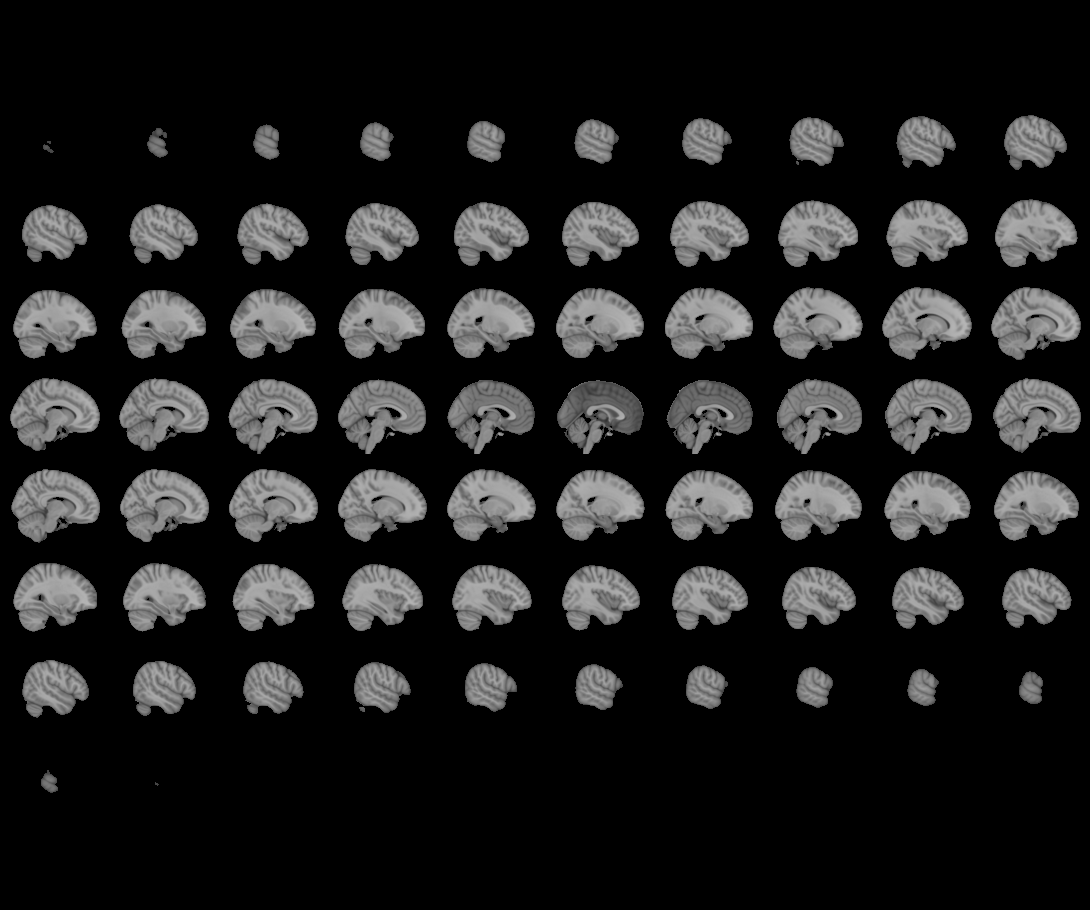
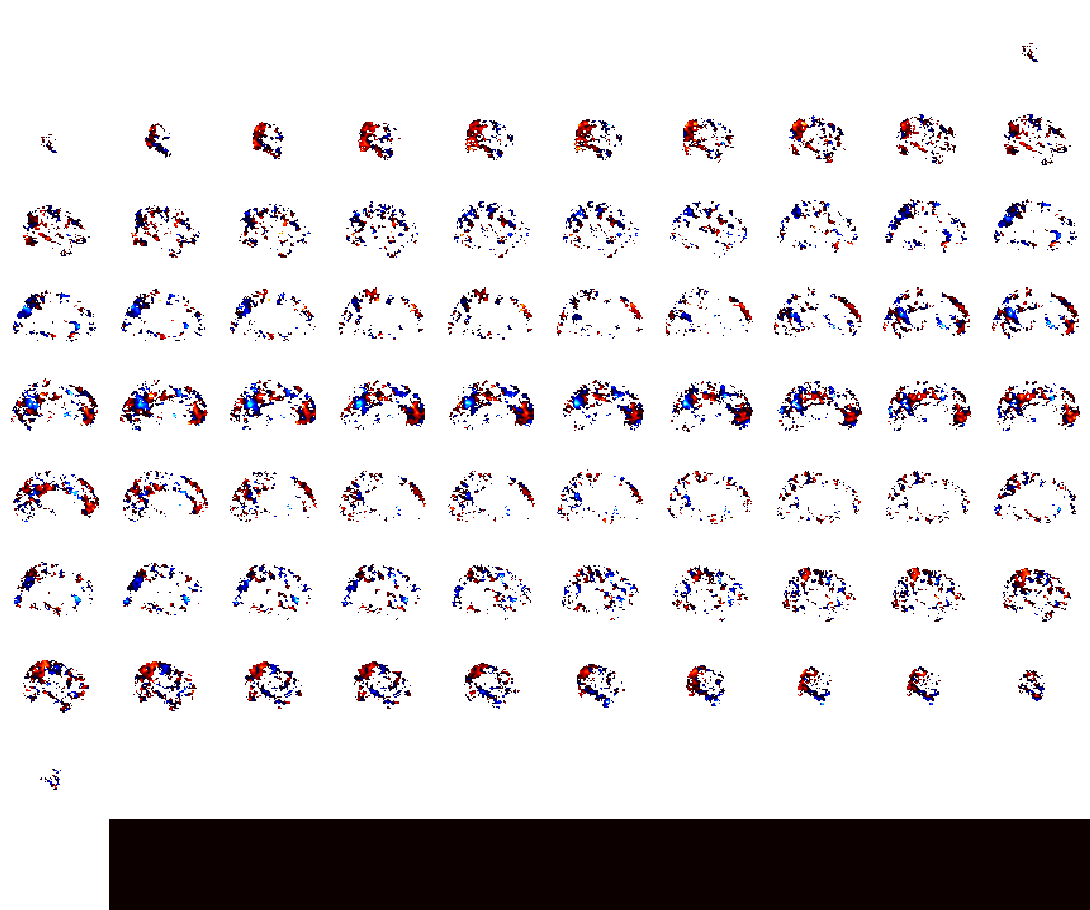

In [78]:
# attention state 
# alpha = 60000
plotting.view_img(task_stats_map)


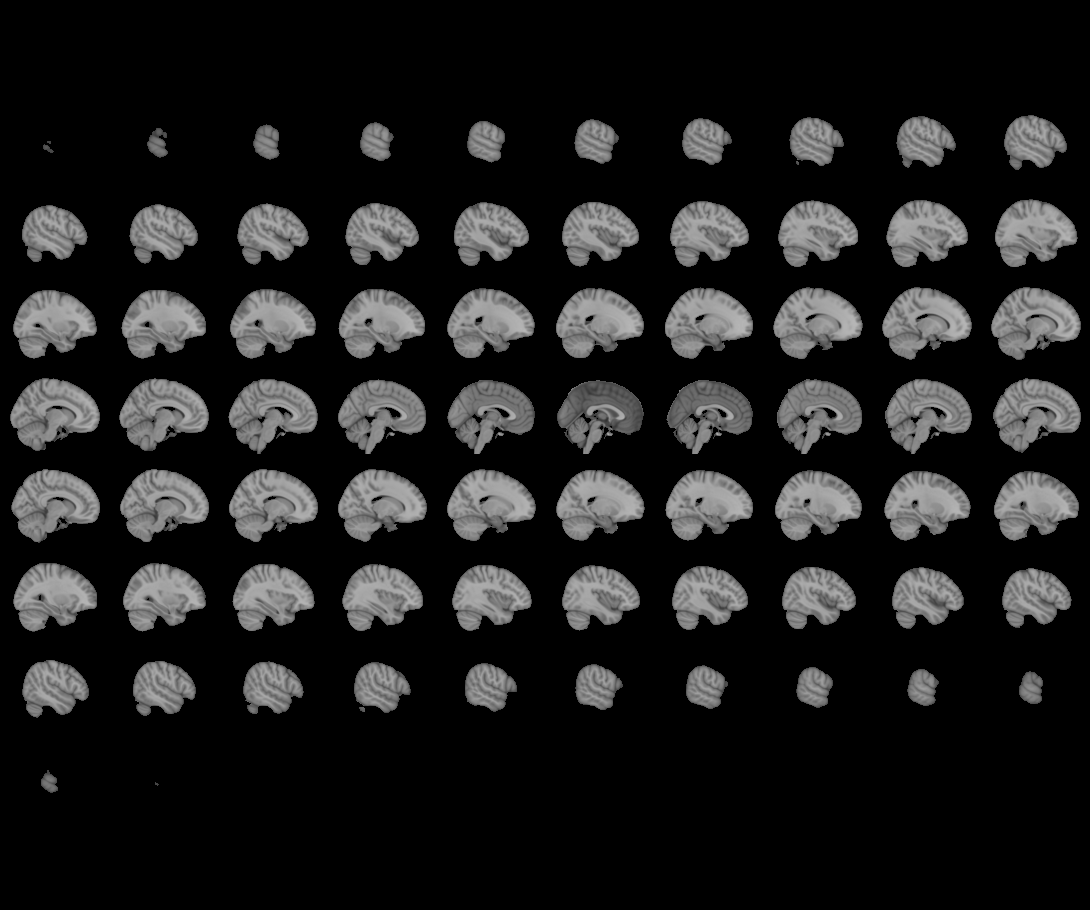
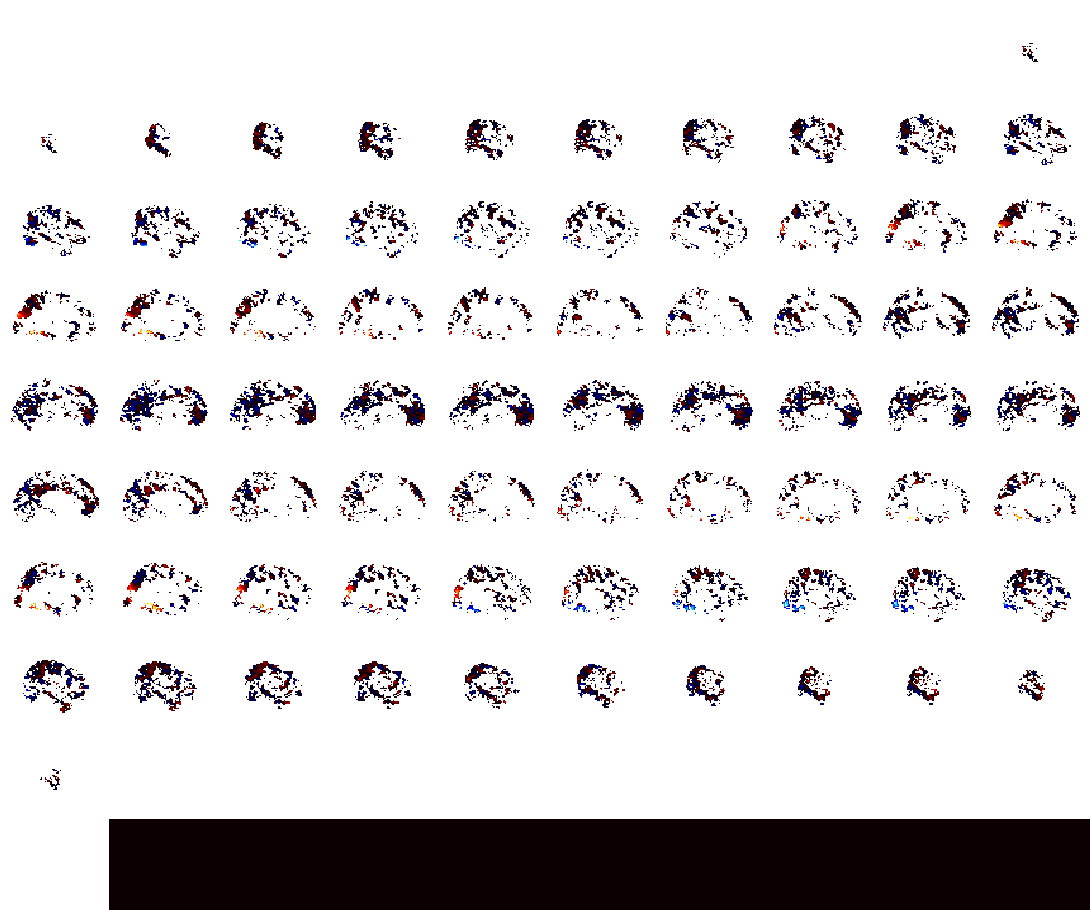

In [105]:
# cue state
# alpha = 5000
plotting.view_img(task_stats_map)


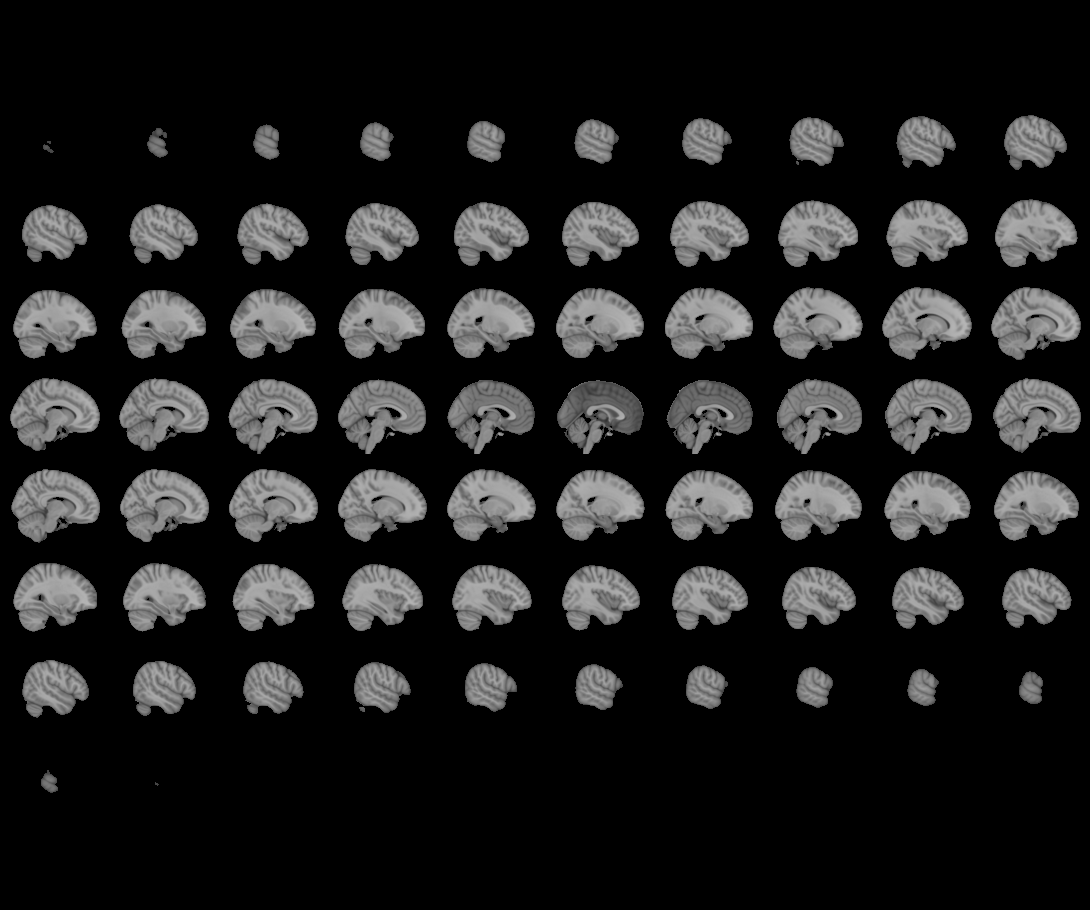
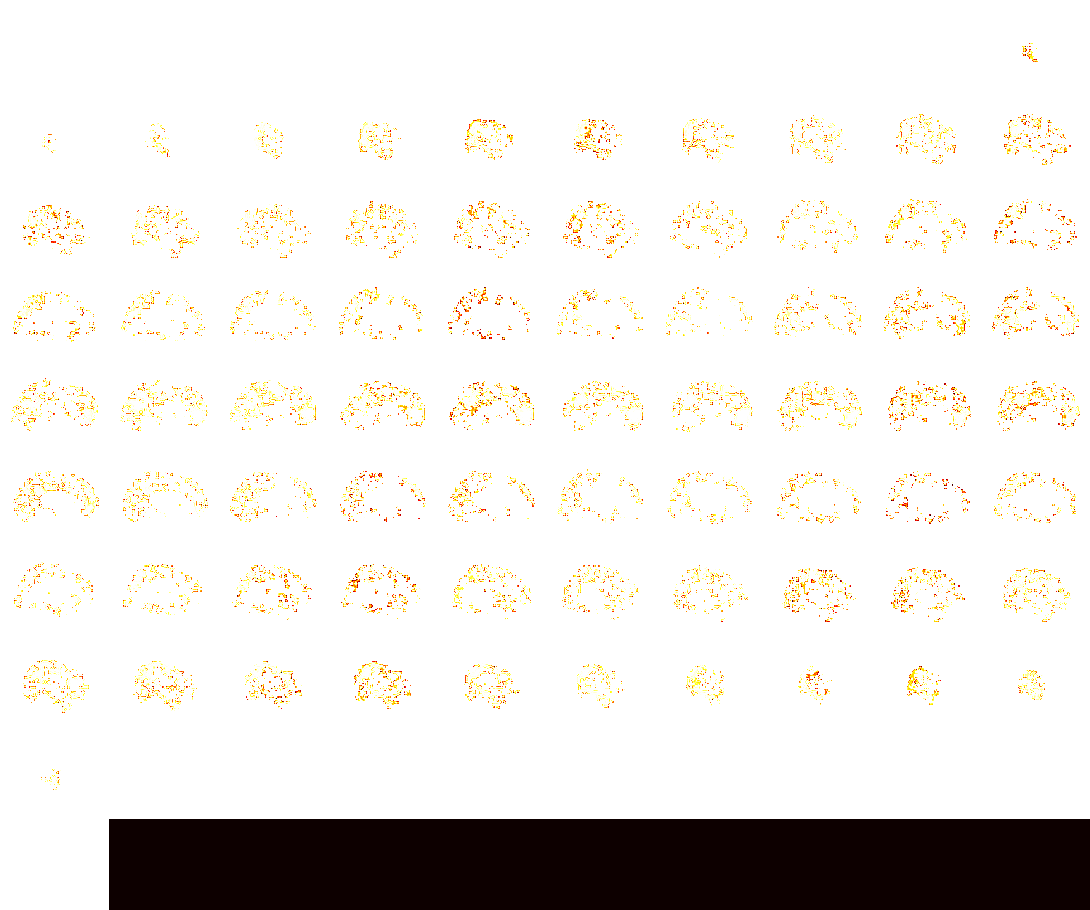

In [69]:
# mask 
plotting.view_img(mask)

## Assign each voxel predicitve accuracy score (from FCMA feature selection)
#### composite score of Retrieve_Perceive and Retrieve_PerceiveScramble

In [209]:
# set up directory 
ret_per_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result/FCMA/sb_gm_mask/'
ret_per_sub = sorted(glob.glob(os.path.join(ret_per_dir,'*_score.nii.gz')), key= lambda x: int(x.split('_')[-3][2:]))
ret_scramble_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_scrambleRetrieve/FCMA/sb_gm_mask/'
ret_scramble_sub = sorted(glob.glob(os.path.join(ret_scramble_dir,'*_score.nii.gz')), key= lambda x: int(x.split('_')[-3][2:]))
out_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/sb_gm_mask/'

# grey matter mask 
gm_mask = image.load_img('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/all_sub_universal_GM_mask.nii.gz')

# loop through each subject, combine two 3d images 
for sub in range(24):
    
    # load ret_per image
    ret_per_nii = image.load_img(ret_per_sub[sub])
    ret_per_dat = ret_per_nii.get_fdata()
    # load ret_perscramble imgae
    ret_scramble_nii = image.load_img(ret_scramble_sub[sub])
    ret_scramble_dat = ret_scramble_nii.get_fdata()
    
    # check dimension 
    if ret_per_dat.shape != ret_scramble_dat.shape:
        print("Shape does not match")
    else: 
        # stack the two 3d image on the 4th dimension
        stack_img = np.stack([ret_per_dat, ret_scramble_dat], axis = 3)
        # for each voxel, select the smaller number
        stack_img_min = np.min(stack_img, axis = 3)
        
        # write out score file
        stack_img_min_nii = image.new_img_like(gm_mask, stack_img_min, affine = gm_mask.affine)
        stack_img_min_nii.to_filename(os.path.join(out_dir, f'fc_no{sub}_ret_per_scramble_composite_score.nii.gz'))
        
        # write out seq file
        gm_voxels = masking.apply_mask(stack_img_min_nii, gm_mask)
        gm_voxels_order = rankdata(gm_voxels, method = 'ordinal')
        gm_voxels_seq = len(gm_voxels) - gm_voxels_order + 1
        gm_voxels_seq_nii = masking.unmask(gm_voxels_seq, gm_mask)
        
        gm_voxels_seq_nii.to_filename(os.path.join(out_dir, f'fc_no{sub}_ret_per_scramble_composite_seq.nii.gz'))
        
        

#### Select top k voxels

In [215]:
# make top n masks
out_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_scramblePerceive/FCMA/sb_gm_mask/'

for n in [100,1000,3000,5000,10000,15000]:
    top_n = 'top_' + str(n)
    subprocess.run("module load fsl", shell = True)
    subprocess.run(f"bash /projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma/make_top_voxel_mask.sh {out_dir} {n} {os.path.join(out_dir, top_n)}", shell = True)

#### Run classification

In [228]:
subprocess.run("module load fsl", shell = True)
subprocess.run("module load miniconda", shell = True)
subprocess.run("conda activate mybrainiak", shell = True)
for n in [1000]:
    top_n = 'top_' + str(n)
    for sub in range(1):
        #print(f"sbatch /projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma/run_fcma_classify.sh /projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ res1956.nii.gz /projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/sb_gm_mask/{top_n}/fc_no{sub}_ret_per_scramble_composite_seq_top{n}.nii.gz /projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/perceive_retrieve_epoch_labels.npy {sub} /projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/sb_gm_mask/{top_n}/")
        subprocess.run(f"sbatch /projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma/run_fcma_classify.sh /projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ res1956.nii.gz /projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/sb_gm_mask/{top_n}/fc_no{sub}_ret_per_scramble_composite_seq_top{n}.nii.gz /projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/perceive_retrieve_epoch_labels.npy {sub} /projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/sb_gm_mask/{top_n}/", shell = True)

In [2]:
epoch_file_scramble_ret = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/permutate_labels_perScramble_ret/perceiveScramble_retrieve_epoch_lables_permutate_run0.npy'
epoch_info_scramble_ret = generate_epochs_info(io.load_labels(epoch_file_scramble_ret))

epoch_file_ret_per = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/permutate_labels_ret_per/retrieve_perceive_epoch_lables_permutate_run0.npy'
epoch_info_ret_per = generate_epochs_info(io.load_labels(epoch_file_ret_per))

## Information mapping based on two contrasts: 
- compute composite score for the permutation data to build null distribution
- composite score was computed by getting the min of the observed data but mean of the null distribution 

In [118]:
# ret-per null data
ret_per_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result/FCMA_permutation/ret_per_permutation/'
ret_per_permutate = sorted(glob.glob(os.path.join(ret_per_dir, '*_score.nii.gz')), key= lambda x: int(x.split('_')[-3][8:]))

# ret-scramble null data
ret_scramble_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result/FCMA_permutation/perScramble_ret_permutation/'
ret_scramble_permutate = sorted(glob.glob(os.path.join(ret_scramble_dir, '*_score.nii.gz')), key= lambda x: int(x.split('_')[-3][8:]))

# function for each iteration, compute the composite score: 
def extract_voxel_mean(ret_per_3d, ret_scramble_3d):
    
    # load ret_per image
    ret_per_nii = image.load_img(ret_per_3d)
    ret_per_dat = ret_per_nii.get_fdata()
    # load ret_perscramble imgae
    ret_scramble_nii = image.load_img(ret_scramble_3d)
    ret_scramble_dat = ret_scramble_nii.get_fdata()

    # check dimension 
    if ret_per_dat.shape != ret_scramble_dat.shape:
        print("Shape does not match")
    else: 
        # stack the two 3d image on the 4th dimension
        stack_img = np.stack([ret_per_dat, ret_scramble_dat], axis = 3)
        # for each voxel, select the smaller number
        stack_img_mean = np.mean(stack_img, axis = 3)

    return(stack_img_mean)

# compute composite score image for each iteration 
composite_score_3d = []
for ret_per_3d, ret_scramble_3d in zip(ret_per_permutate, ret_scramble_permutate):
    composite_score_3d.append(extract_voxel_mean(ret_per_3d, ret_scramble_3d))

# reference image
ref = image.load_img('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/all_sub_universal_GM_mask.nii.gz')

# stack up 100 iterations: 
permutation_composite_4d = np.stack(composite_score_3d, axis = 3)
permutation_composite_4d_nii = image.new_img_like(ref, permutation_composite_4d, ref.affine)
permutation_composite_4d_nii.to_filename('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/ret_per_scramble_composite_information_mapping/composite_mean/permutate_dat_4d.nii.gz')


# zscore along the iteration dimention 
#permutation_composite_4d_zscore = zscore(permutation_composite_4d, axis=3, ddof=0)
#permutation_composite_4d_zscore = np.nan_to_num(permutation_composite_4d_zscore)
# make a new NIFTI file and save it
#permutation_composite_4d_zscore_nii = image.new_img_like(ref, permutation_composite_4d, ref.affine)
#permutation_composite_4d_zscore_nii.to_filename('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/ret_per_scramble_composite_information_mapping/composite_min/permutate_dat_4d.nii.gz')


In [224]:
# load all actual data (composite score)
inner_cv_dat_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/FCMA_composite_score/sb_gm_mask'
inner_cv_dat = glob.glob(os.path.join(inner_cv_dat_dir, "*_score.nii.gz"))
# stack them along the 4th axis
inner_cv_dat_4d = np.stack([image.load_img(dat).get_fdata() for dat in inner_cv_dat], axis = 3)

# averaged acc for each voxel
inner_cv_dat_mean = np.mean(inner_cv_dat_4d, axis = 3)
# mean and sd for each voxel for null distribution
permutate_dat_mean = np.mean(permutation_composite_4d, axis = 3)
permutate_dat_sd = np.std(permutation_composite_4d, axis = 3)

# z score the observed data based on the null distribution 
inner_cv_dat_zscore = (inner_cv_dat_mean - permutate_dat_mean)/permutate_dat_sd
inner_cv_dat_zscore = np.nan_to_num(inner_cv_dat_zscore)

inner_cv_dat_zscore_nii = image.new_img_like(ref, inner_cv_dat_zscore, ref.affine)
#inner_cv_dat_zscore_nii.to_filename('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/ret_per_scramble_composite_information_mapping/composite_mean/inner_cv_composite_zscore.nii.gz')



/packages/miniconda/20190102/envs/anaconda-tensorflow-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [241]:
pass_thres_vox = image.load_img('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/ret_per_scramble_composite_information_mapping/composite_min/cluster0001.nii.gz')
new_mask = np.zeros(ref.get_data().shape)
new_mask[np.where(pass_thres_vox.get_fdata() > 0)] = 1
new_mask_nii = image.new_img_like(ref, new_mask, affine = ref.affine)
new_mask_nii.to_filename('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/ret_per_scramble_composite_information_mapping/composite_min/cluster0001_binary_mask.nii.gz')

In [ ]:
# -----------------------------------
# Preprocessing for task-evoked data
# -----------------------------------

# Evoked_response directory
evoked_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/evoked_response/'
evoked_images = io.load_images_from_dir(evoked_dir, suffix='CONCAT.nii.gz')

# FCMA identified top_3000 roi clusters
mask_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/ret_per_scramble_composite_information_mapping/composite_mean/afni_clusters/'
roi_masks_boo = [io.load_boolean_mask(mask) for mask in sorted(glob.glob(os.path.join(mask_dir, '*nii.gz')), key = lambda x: int(x.split('_')[-3]))]

# a list of 24 subjects, of a list of 8 masks of a 2d array (nvoxel in the mask, 1956 tr)
evoked_ts = list(multimask_images(evoked_images, roi_masks_boo, np.float32))

# ---------------------
# save the evoked_ts_np
# ---------------------

# get the roi names given the order of the mask 
mask_order = sorted(glob.glob(os.path.join(mask_dir, '*nii.gz')), key = lambda x: int(x.split('_')[-3]))
mask_name = [filename.split(".")[0] for filename in [filename.split("/")[-1] for filename in mask_order]]

# make the npy for each mask (sub, nvoxel, tr)
for ind, name in enumerate(mask_name):
    # the 3d npy for a given mask
    mask_npy = np.stack(np.stack(evoked_ts, axis = 0)[:,ind].tolist(),axis = 0)
    # save this npy
    np.save(f'/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/{name}_eovked_dat_SubVoxTR_fullts.npy', mask_npy)
    
        

In [1]:
evoked_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/evoked_response/'
evoked_images = io.load_images_from_dir(evoked_dir, suffix='CONCAT.nii.gz')

NameError: name 'io' is not defined

## Check cor mat for afni clusters -- Cluster Level:

In [83]:
def _separate_epochs(activity_data, epoch_list):
    """ create data epoch by epoch

    Separate data into conditions of interest specified in epoch_list

    Parameters
    ----------
    activity_data: list of 2D array in shape [nVoxels, nTRs]
        the masked activity data organized in voxel*TR formats of all subjects
    epoch_list: list of 3D array in shape [condition, nEpochs, nTRs]
        specification of epochs and conditions
        assuming all subjects have the same number of epochs
        len(epoch_list) equals the number of subjects

    Returns
    -------
    raw_data: list of 2D array in shape [nParcels, timepoints (36*16)]
        the data organized in epochs
        len(raw_data) equals 48 (24 subjects, 2 conditions for each subject for retrieve vs. perceive. )
    labels: list of 1D array
        the condition labels of the epochs
        len(labels) labels equals the number of epochs
    """
    raw_data = []
    labels = []
    for sid in range(len(epoch_list)): #for a given subject
        epoch = epoch_list[sid] # get their npy array
        for cond in range(epoch.shape[0]): # for a given condition
            # for each condition
            sub_epoch = epoch[cond, :, :]
            ts = np.zeros(1956)
            for eid in range(epoch.shape[1]):
                r = np.sum(sub_epoch[eid, :])
                if r > 0:   # there is an epoch in this condition
                    # collapse all epoch of a condition to a single time series
                    ts[sub_epoch[eid, :] == 1] = 1
            ts = ts.astype(np.bool)
            mat_cond = activity_data[sid][:,ts]
            mat_cond = np.ascontiguousarray(mat_cond)
            raw_data.append(mat_cond)
            labels.append(cond)

    return raw_data, labels

bg_ts = []
base_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/background_dat/composite_score_information_mapping_afni_clusters/'
bg_ts_dir = sorted(glob.glob(os.path.join(base_dir, "*")), key = lambda x: int(x.split('_')[-7]))[0:16]

# epoch files:
ret_per_epoch_list = np.load('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/perceive_retrieve_epoch_labels.npy')
scramble_ret_epoch_list = np.load('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/scramble_retrieve_epoch_lables.npy')
scramble_per_epoch_list = np.load('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/scramble_perceive_epoch_lables.npy')

# list of 2d arrays, each for a cluster. 
ret_subClusterTR, per_subClusterTR, scramble_subClusterTR = [],[],[]
for file in bg_ts_dir:
    cluster_subVoxTR = np.load(file)
    # preprocess the data;
    
    # ret vs. per
    raw_data_ret_per, labels_ret_per = _separate_epochs(cluster_subVoxTR, ret_per_epoch_list)
    raw_data_ret_per_mean = [np.mean(x, axis = 0) for x in raw_data_ret_per]
    raw_data_ret_mean = [raw_data_ret_per_mean[cond] for cond in np.where(np.array(labels_ret_per) == 0)[0].tolist()]
    raw_data_per_mean = [raw_data_ret_per_mean[cond] for cond in np.where(np.array(labels_ret_per) == 1)[0].tolist()]
    
    # scramble vs. ret
    raw_data_scramble_ret, labels_scramble_ret = _separate_epochs(cluster_subVoxTR, scramble_ret_epoch_list)
    raw_data_scramble_ret_mean = [np.mean(x, axis = 0) for x in raw_data_scramble_ret]
    raw_data_scramble_mean = [raw_data_scramble_ret_mean[cond] for cond in np.where(np.array(labels_scramble_ret) == 0)[0].tolist()]
    raw_data_ret_mean2 = [raw_data_scramble_ret_mean[cond] for cond in np.where(np.array(labels_scramble_ret) == 1)[0].tolist()]
    
    # scramble vs. per
    raw_data_scramble_per, labels_scramble_per = _separate_epochs(cluster_subVoxTR, scramble_per_epoch_list)
    raw_data_scramble_per_mean = [np.mean(x, axis = 0) for x in raw_data_scramble_per]
    raw_data_scramble_mean2 = [raw_data_scramble_per_mean[cond] for cond in np.where(np.array(labels_scramble_per) == 0)[0].tolist()]
    raw_data_per_mean2 = [raw_data_scramble_per_mean[cond] for cond in np.where(np.array(labels_scramble_per) == 1)[0].tolist()]
    
    check_ret = np.unique([(x == y).all() for x,y in zip(raw_data_ret_mean,raw_data_ret_mean2)])
    check_per = np.unique([(x == y).all() for x,y in zip(raw_data_per_mean,raw_data_per_mean2)])
    check_scramble = np.unique([(x == y).all() for x,y in zip(raw_data_scramble_mean,raw_data_scramble_mean2)])
    
    if check_ret & check_per & check_scramble != True:
        print("Something is wrong")
        break
    
    ret_subClusterTR.append(np.stack(raw_data_ret_mean, axis = 0))
    per_subClusterTR.append(np.stack(raw_data_per_mean, axis = 0))
    scramble_subClusterTR.append(np.stack(raw_data_scramble_mean, axis = 0))

# stack all clusters up into a 3d np array
ret_subClusterTR_3d = np.stack(ret_subClusterTR, axis = 1)
per_subClusterTR_3d = np.stack(per_subClusterTR, axis = 1)
scramble_subClusterTR_3d = np.stack(scramble_subClusterTR, axis = 1)

# get FC pattern across the 16 clusters during the 3 conditions
ret_corMat_mean = np.mean([np.corrcoef(ret_subClusterTR_3d[sub,:,:]) for sub in range(24)], axis = 0)
per_corMat_mean = np.mean([np.corrcoef(per_subClusterTR_3d[sub,:,:]) for sub in range(24)], axis = 0)
scramble_corMat_mean = np.mean([np.corrcoef(scramble_subClusterTR_3d[sub,:,:]) for sub in range(24)], axis = 0)

# get FC pattern specifically for internal vs. external attention 


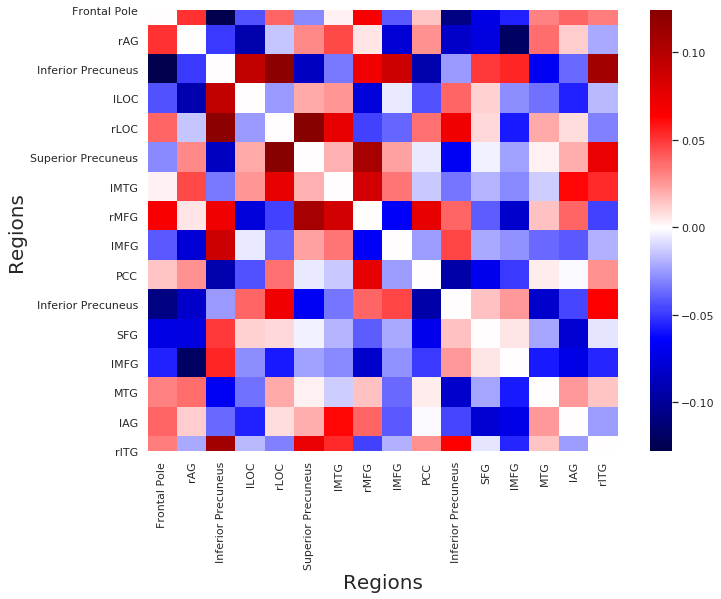

In [197]:
# plot
sns.set(style="white");
plt.subplots(figsize=(10,7)); cmap = sns.diverging_palette(220, 10, as_cmap=True);
axis_labels = ["Frontal Pole","rAG","Inferior Precuneus","lLOC","rLOC","Superior Precuneus","lMTG","rMFG","lMFG","PCC","Inferior Precuneus","SFG","lMFG","MTG","lAG","rITG"]
sns.heatmap(ret_corMat_mean - scramble_corMat_mean,center=0,cmap='seismic',square=True,xticklabels=axis_labels,yticklabels=axis_labels);
plt.ylabel('Regions',fontsize=20); plt.xlabel('Regions',fontsize=20);
plt.subplots_adjust(left=None, bottom=None, right=1, top=1, wspace=1, hspace=1);

## Check cor mat for afni clusters -- voxel Level:

In [63]:
def _separate_epochs(activity_data, epoch_list):
    """ create data epoch by epoch

    Separate data into conditions of interest specified in epoch_list

    Parameters
    ----------
    activity_data: list of 2D array in shape [nVoxels, nTRs]
        the masked activity data organized in voxel*TR formats of all subjects
    epoch_list: list of 3D array in shape [condition, nEpochs, nTRs]
        specification of epochs and conditions
        assuming all subjects have the same number of epochs
        len(epoch_list) equals the number of subjects

    Returns
    -------
    raw_data: list of 2D array in shape [nParcels, timepoints (36*16)]
        the data organized in epochs
        len(raw_data) equals 48 (24 subjects, 2 conditions for each subject for retrieve vs. perceive. )
    labels: list of 1D array
        the condition labels of the epochs
        len(labels) labels equals the number of epochs
    """
    raw_data = []
    labels = []
    for sid in range(len(epoch_list)): #for a given subject
        epoch = epoch_list[sid] # get their npy array
        for cond in range(epoch.shape[0]): # for a given condition
            # for each condition
            sub_epoch = epoch[cond, :, :]
            ts = np.zeros(1956)
            for eid in range(epoch.shape[1]):
                r = np.sum(sub_epoch[eid, :])
                if r > 0:   # there is an epoch in this condition
                    # collapse all epoch of a condition to a single time series
                    ts[sub_epoch[eid, :] == 1] = 1
            ts = ts.astype(np.bool)
            mat_cond = activity_data[sid][:,ts]
            mat_cond = np.ascontiguousarray(mat_cond)
            raw_data.append(mat_cond)
            labels.append(cond)

    return raw_data, labels

bg_ts = []
base_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/background_dat/composite_score_information_mapping_afni_clusters/'
bg_ts_dir = sorted(glob.glob(os.path.join(base_dir, "*")), key = lambda x: int(x.split('_')[-7]))[0:16]

# epoch files:
ret_per_epoch_list = np.load('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/perceive_retrieve_epoch_labels.npy')
scramble_ret_epoch_list = np.load('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/scramble_retrieve_epoch_labels.npy')
scramble_per_epoch_list = np.load('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/scramble_perceive_epoch_labels.npy')

# list of 2d arrays, each for a cluster. 
ret_subVoxTR, per_subVoxTR, scramble_subVoxTR = [],[],[]
voxel_count = []
cluster_count = []
for file in bg_ts_dir[0:10]:
    cluster_subVoxTR = np.load(file)
    # preprocess the data;
    if len(voxel_count) > 0:
        voxel_count.append(voxel_count[-1] + cluster_subVoxTR.shape[1])
    else: 
        voxel_count.append(cluster_subVoxTR.shape[1])
    cluster_count.append(cluster_subVoxTR.shape[1])
    
    # ret vs. per
    raw_data_ret_per, labels_ret_per = _separate_epochs(cluster_subVoxTR, ret_per_epoch_list)
    raw_data_ret = [raw_data_ret_per[cond] for cond in np.where(np.array(labels_ret_per) == 0)[0].tolist()]
    raw_data_per = [raw_data_ret_per[cond] for cond in np.where(np.array(labels_ret_per) == 1)[0].tolist()]
    
    # scramble vs. ret
    raw_data_scramble_ret, labels_scramble_ret = _separate_epochs(cluster_subVoxTR, scramble_ret_epoch_list)
    raw_data_scramble = [raw_data_scramble_ret[cond] for cond in np.where(np.array(labels_scramble_ret) == 0)[0].tolist()]
    raw_data_ret2 = [raw_data_scramble_ret[cond] for cond in np.where(np.array(labels_scramble_ret) == 1)[0].tolist()]
    
    # scramble vs. per
    raw_data_scramble_per, labels_scramble_per = _separate_epochs(cluster_subVoxTR, scramble_per_epoch_list)
    raw_data_scramble2 = [raw_data_scramble_per[cond] for cond in np.where(np.array(labels_scramble_per) == 0)[0].tolist()]
    raw_data_per2 = [raw_data_scramble_per[cond] for cond in np.where(np.array(labels_scramble_per) == 1)[0].tolist()]
    
    check_ret = np.unique([(x == y).all() for x,y in zip(raw_data_ret,raw_data_ret2)])
    check_per = np.unique([(x == y).all() for x,y in zip(raw_data_per,raw_data_per2)])
    check_scramble = np.unique([(x == y).all() for x,y in zip(raw_data_scramble,raw_data_scramble2)])
    
    if check_ret & check_per & check_scramble != True:
        print("Something is wrong")
        break
    
    ret_subVoxTR.append(np.stack(raw_data_ret, axis = 0))
    per_subVoxTR.append(np.stack(raw_data_per, axis = 0))
    scramble_subVoxTR.append(np.stack(raw_data_scramble, axis = 0))

# stack all clusters up into a 3d np array
ret_subVoxTR_3d = np.concatenate(ret_subVoxTR, axis = 1)
per_subVoxTR_3d = np.concatenate(per_subVoxTR, axis = 1)
scramble_subVoxTR_3d = np.concatenate(scramble_subVoxTR, axis = 1)

# get FC pattern across the 16 clusters during the 3 conditions
ret_corMat_mean = np.mean([np.corrcoef(ret_subVoxTR_3d[sub,:,:]) for sub in range(24)], axis = 0)
per_corMat_mean = np.mean([np.corrcoef(per_subVoxTR_3d[sub,:,:]) for sub in range(24)], axis = 0)
scramble_corMat_mean = np.mean([np.corrcoef(scramble_subVoxTR_3d[sub,:,:]) for sub in range(24)], axis = 0)

# get FC pattern specifically for internal vs. external attention 



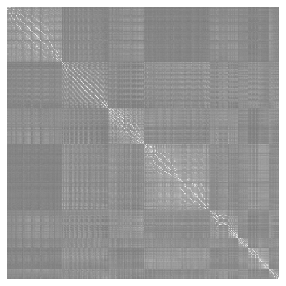

In [64]:
%matplotlib inline
# Generate figure 
sns.set(style="white")
fig, ax = plt.subplots(figsize=(5,5));
ax.tick_params(axis='both', which='both', length=0)
sns.heatmap(per_corMat_mean,center=0, cmap = "gray",square=True, cbar=False, xticklabels= False, yticklabels= False);


#plt.savefig('/projects/hulacon/peetal/FC_pattern_per.png', dpi=300)

In [417]:
import matplotlib.patches as patches
fcmat = ret_corMat_mean - scramble_corMat_mean
colorList = ["gray","firebrick","sandybrown","moccasin","olivedrab","chartreuse","paleturquoise","deepskyblue","navy","plum",
             "mediumvioletred","khaki","teal","cyan","aliceblue","darkviolet"];
# corresponding to each cluster
netBoundaries = [(0,619,620),(620,1138,519),(1139,1538,400),(1539,1915,377),(1916,2279,364),(2280,2587,308),(2588,2704,117),(2705,2820,116),\
                 (2821,2936,116),(2937,3043,107),(3044,3146,103),(3147,3228,82),(3229,3292,64),(3293,3350,58),(3351,3402,52),(3403,3451,49)]; 
[nParcels,nParcels] = np.shape(fcmat); 
numNets = np.shape(colorList)[0]

# Make room in FC matrix for network colors 
pad = 100
bottomSize, topSize = (pad,nParcels), (nParcels+pad,pad)
bottomBuff, topBuff = np.zeros(bottomSize), np.zeros(topSize)
bottomBuff = (bottomBuff+1)*0.1; 
topBuff = (topBuff+1)*0.1; # 0.31 is somewhat arbitrary, if it looks funny, change this number
bottomAdd = np.vstack((fcmat,bottomBuff)); 
fcMatrixWithBuffer = np.hstack((bottomAdd,topBuff)); 
np.fill_diagonal(fcMatrixWithBuffer, 0);

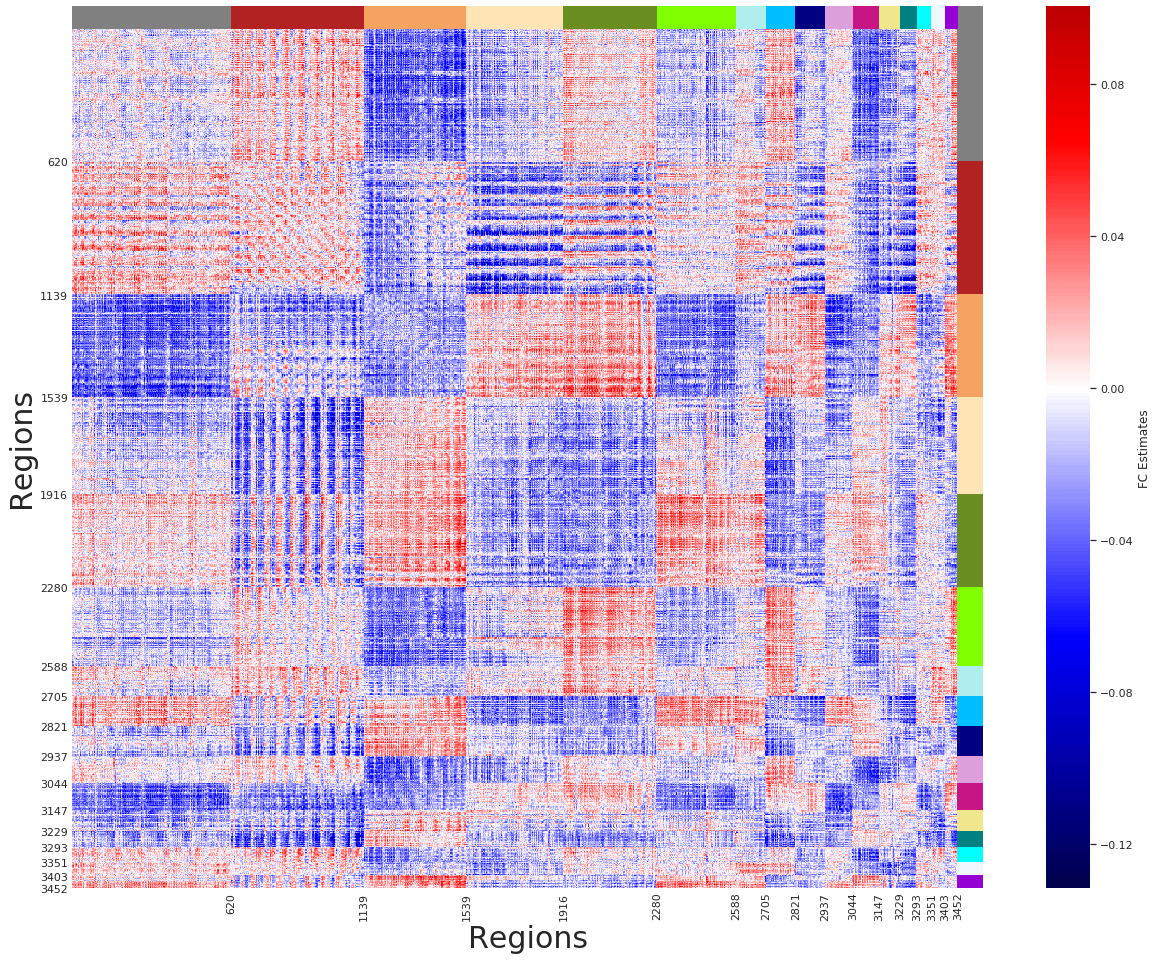

In [418]:
# Generate figure 
sns.set(style="white");
fig, ax = plt.subplots(figsize=(20,14)); cmap = sns.diverging_palette(220, 10, as_cmap=True);
tickLabels = voxel_count; 
sns.heatmap(fcMatrixWithBuffer,center=0,cmap='seismic',square=True,cbar_kws={'label': 'FC Estimates'},xticklabels=tickLabels ,yticklabels=tickLabels );
plt.ylabel('Regions',fontsize=30); 
plt.xlabel('Regions',fontsize=30);
plt.subplots_adjust(left=None, bottom=None, right=1, top=1, wspace=1, hspace=1);
    
# Add network colors to the "buffered" axes 
netList = list(range(numNets));
for net in netList: 
    thisNet = netBoundaries[net]; netSize = thisNet[2]; netStart = thisNet[0]; 
    rectH = patches.Rectangle((netStart-1,0),netSize,pad,linewidth=1,edgecolor=colorList[net],facecolor=colorList[net]); 
    rectV = patches.Rectangle((3451,netStart-1),pad,netSize,linewidth=1,edgecolor=colorList[net],facecolor=colorList[net]); 
    ax.add_patch(rectH); 
    ax.add_patch(rectV);
    
rectWhite = patches.Rectangle((nParcels-1,nParcels-1),pad,pad,linewidth=1,edgecolor='white',facecolor='white'); ax.add_patch(rectWhite); 

# set global params & show image 
plt.box(0); ax.set_xticks(tickLabels); ax.set_yticks(tickLabels); 
plt.rc('ytick',labelsize=10); plt.rc('xtick',labelsize=10); 
ax.tick_params(axis=u'both', which=u'both',length=0); plt.box(0); 
plt.show()

fig.savefig("/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/output.png")
    

## Extract clusters larger than 10 voxels for the p<0.0001 voxels, FSL cluster output

In [75]:
# base directory:
base_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/ret_per_scramble_composite_information_mapping/composite_m/'

# load the voxels (cluster) map that pass the threshold (output from FSL cluster):
cluster_nii_dir = os.path.join(base_dir, 'cluster0001.nii.gz')
# the text file about the cluster information:
cluster_info_dir = os.path.join(base_dir,'cluster0001_info.txt')


def extract_cluster_binary_mask(cluster_nii_dir, cluster_info_dir, cluster_size_cutoff):
    """
    cluster_nii_dir: path to the nii file, which is the output from FSL cluster command.
    cluster_info_dir: path to the txt file, the txt output from FSL cluster.
    cluster_size_cutoff: clusters that of sizes above this threshold would be counted. 
    """
    cluster_nii = image.load_img(cluster_nii_dir)
    cluster_info = pd.read_csv(cluster_info_dir, sep = '\t')
    
    # extract cluster indecies that pass the cluster size cutoff
    cluster_idx = cluster_info.loc[cluster_info['Voxels'] > cluster_size_cutoff, "Cluster Index"].tolist()
    cluster_size = cluster_info.loc[cluster_info['Voxels'] > cluster_size_cutoff, "Voxels"].tolist()
    
    # iterate through each index and extract the corresponding cluster, and binarize it into a mask. 
    cluster_nii_dat = cluster_nii.get_fdata()
    for idx, size in zip(cluster_idx, cluster_size):
        
        # create an empty mask
        current_cluster_mask = np.zeros(cluster_nii_dat.shape)
        # fill the mask with the current cluster:
        current_cluster_mask[np.where(cluster_nii_dat == idx)] = 1
        
        # check size 
        if np.sum(current_cluster_mask) != size: 
            print("Cluster size is off")
            break
        
        # save the mask 
        current_cluster_mask_nii = image.new_img_like(cluster_nii, current_cluster_mask, affine = cluster_nii.affine)
        current_cluster_mask_nii.to_filename(os.path.join(base_dir,"cluster_above10",f"cluster_{idx}_size_{size}.nii.gz"))

# run it
_ = extract_cluster_binary_mask(cluster_nii_dir,cluster_info_dir, 10)
        
        
    
    

In [171]:
# -----------------------------------
# Preprocessing for bg data
# -----------------------------------

# Evoked_response directory
bg_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/'
bg_images = io.load_images_from_dir(bg_dir, suffix='res1956.nii.gz')

# FCMA identified top_3000 roi clusters
mask_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/ret_per_scramble_composite_information_mapping/composite_mean/afni_clusters/'
roi_masks_boo = [io.load_boolean_mask(mask) for mask in sorted(glob.glob(os.path.join(mask_dir, '*nii.gz')),key= lambda x: int(x.split('_')[-3]))]

# a list of 24 subjects, of a list of 8 masks of a 2d array (nvoxel in the mask, 1956 tr)
bg_ts = list(multimask_images(bg_images, roi_masks_boo, np.float32))

# ---------------------
# save the bg_ts_np
# ---------------------

# get the roi names given the order of the mask 
mask_order = sorted(glob.glob(os.path.join(mask_dir, '*nii.gz')),key= lambda x: int(x.split('_')[-3]))
mask_name = [filename[:-7].split("/")[-1] for filename in mask_order]

# make the npy for each mask (sub, nvoxel, tr)
for ind, name in enumerate(mask_name):
    # the 3d npy for a given mask
    mask_npy = np.stack(np.stack(bg_ts, axis = 0)[:,ind].tolist(),axis = 0)
    # save this npy
    np.save(f'/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/background_dat/composite_score_information_mapping_afni_clusters/{name}_bg_dat_SubVoxTR_fullts.npy', mask_npy)
    
        

In [160]:
# FCMA identified top_3000 roi clusters
mask_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/ret_per_scramble_composite_information_mapping/composite_mean/afni_clusters/'
roi_masks_boo = [io.load_boolean_mask(mask) for mask in sorted(glob.glob(os.path.join(mask_dir, '*nii.gz')), key = )]

In [173]:
mask_npy.shape

(24, 6, 1956)

## Add clusters 1 by 1 and see when does outer-loop FCMA classification accuracy plateaus

In [120]:
# load cluster file from AFNI 3dClusterize, NN = 3, p < 0.0001 based on null distribution: 
afni_cluster = image.load_img('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/ret_per_scramble_composite_information_mapping/composite_mean/afni_cluster.nii.gz')
output_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/FCMA_composite_score_information_mapping/'
afni_cluster_dat = afni_cluster.get_fdata()
new_mask = np.zeros(afni_cluster_dat.shape)

In [121]:
# Add cluster one by one by the order of size 
for cluster_count in np.unique(afni_cluster_dat):
    # skip 0 
    if cluster_count == 0:
        True
    else: 
        new_mask[np.where(afni_cluster_dat == cluster_count)] = 1  # binary mask for a given cluster and all clusters before 
        # total number of voxels in the mask 
        voxel_count = np.sum(new_mask)
        new_mask_nii = image.new_img_like(afni_cluster, new_mask, affine = afni_cluster.affine)
        os.mkdir(os.path.join(output_dir, f"{int(cluster_count)}_clusters_{int(voxel_count)}_voxels_mask"))
        new_mask_nii.to_filename(os.path.join(output_dir, f"{int(cluster_count)}_clusters_{int(voxel_count)}_voxels_mask", f"{int(cluster_count)}_clusters_{int(voxel_count)}_voxels_mask.nii.gz"))
        
        

In [4]:
from itertools import product
# write a function to extract left-out subject id and the classification acc. 
def extract_clf_acc(base_dir, cluster_count, voxel_count, cond):
    
    import os
    import numpy as np
    import pandas as pd
    path = os.path.join(base_dir, f"{cluster_count}_clusters_{voxel_count}_voxels_mask", cond, 'classify_result.txt')

    # read each line, from which extract the left out subject id and the clf acc
    with open(path, "r") as file:
        lines = file.readlines()
    acc = []
    for line in lines: 

        acc_start_index = line.index(': ') + 2
        acc_end_index = line.index('\n')
        score = float(line[acc_start_index:acc_end_index])
        acc.append(score)

    # write a dataframe
    
    colnames = ['clf_acc','cluster_count','voxel_count','condition']
    df = pd.DataFrame(index=range(len(acc)), columns=colnames)
    df['clf_acc'] = acc
    df['cluster_count'] = np.repeat(cluster_count, len(acc)).tolist()
    df['voxel_count'] = np.repeat(voxel_count, len(acc)).tolist()
    df['condition'] = np.repeat(cond, len(acc)).tolist()
        
    return df

base_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/FCMA_composite_score_information_mapping/'
df_list = []
cluster_map = [os.path.basename(x) for x in sorted(glob.glob(os.path.join(base_dir, "*")), key= lambda x: int(x.split('_')[-5][8:]))]
cluster_count = [x.split("_")[0] for x in cluster_map]
voxel_count = [x.split("_")[2] for x in cluster_map]
# generate df and concatenate them together
#for cond, top_n in product(['ret_per_clf', 'scramble_per_clf', 'scramble_ret_clf'], ['top_100', 'top_1000', 'top_3000', 'top_5000', 'top_10000', 'top_15000']):
    #df_list.append(extract_clf_acc(base_dir,top_n, cond))
for cond in ['ret_per_clf','scramble_ret_clf','scramble_per_clf']:
    for c_count, v_count in zip(cluster_count, voxel_count):
        df_list.append(extract_clf_acc(base_dir, c_count, v_count, cond))

final_df = pd.concat(df_list).reset_index(drop=True)

final_df.to_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/FCMA_composite_score_information_mapping/clf_result_for_all_2way_clf.csv')

## Extract map for each cluster: 

In [159]:
# base directory:
base_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/ret_per_scramble_composite_information_mapping/composite_mean/'

# load the voxels (cluster) map that pass the threshold (output from FSL cluster):
cluster_nii_dir = os.path.join(base_dir, 'afni_cluster.nii.gz')

def extract_cluster_binary_mask(cluster_nii_dir, cluster_size_cutoff):
    """
    cluster_nii_dir: path to the nii file, which is the output from AFNI cluster command.
    cluster_size_cutoff: clusters that of sizes above this threshold would be counted. 
    """
    cluster_nii = image.load_img(cluster_nii_dir)
    
    # iterate through each index and extract the corresponding cluster, and binarize it into a mask. 
    cluster_nii_dat = cluster_nii.get_fdata()
    cluster_idx = np.unique(cluster_nii_dat)[1:]
    for idx in cluster_idx:
        
        # create an empty mask
        current_cluster_mask = np.zeros(cluster_nii_dat.shape)
        # fill the mask with the current cluster:
        current_cluster_mask[np.where(cluster_nii_dat == idx)] = 1
        
        # check size 
        size = np.sum(current_cluster_mask)
        
        # save the mask 
        current_cluster_mask_nii = image.new_img_like(cluster_nii, current_cluster_mask, affine = cluster_nii.affine)
        current_cluster_mask_nii.to_filename(os.path.join(base_dir,"afni_clusters",f"cluster_{int(idx)}_size_{int(size)}.nii.gz"))

# run it
_ = extract_cluster_binary_mask(cluster_nii_dir,0)

## Check predicted accuracy after shuffling the label

In [81]:
clf_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/FCMA_composite_score_16cluster_permutation/ret_per/classify_result.txt'
with open(clf_file, "r") as file:
    lines = file.readlines()

acc = []
for line in lines: 
    acc_start_index = line.index(': ') + 2
    acc_end_index = line.index('\n')
    score = float(line[acc_start_index:acc_end_index])
    acc.append(score)
    

## Evoked response analyses for Attention State (Exclude scramble condition). 

In [37]:
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/perceive_retrieve_epoch_labels_MVPA.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
#activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/background_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:

    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]

    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape

    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)

    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    # For each cluster, average ts across each epoch for each voxel. 
    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)

    within_state_ps_persub = []
    between_state_ps_persub = []

    for i in range(24):

        # get all 32 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]

        cond1_run1 = sub_raw_data_list[0:8]
        cond1_run2 = sub_raw_data_list[8:16]
        cond2_run1 = sub_raw_data_list[16:24]
        cond2_run2 = sub_raw_data_list[24:32]
        within_state_ps = []
        between_state_ps = []

        # compute within-attention state PS
        for eid, epoch in enumerate(sub_raw_data_list):
            if eid < 8: # cond1_run1 (retrieve)
                within_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond1_run2]))
                between_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond2_run1+cond2_run2]))
            elif 8 <= eid < 16: # cond1_run2 (retrieve)
                within_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond1_run1]))
                between_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond2_run1+cond2_run2]))
            elif 16 <= eid < 24: # cond2_run1 (perceive)
                within_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond2_run2]))
                between_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond1_run1+cond1_run2]))
            elif 24 <= eid: # cond2_run2 (perceive)
                within_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond2_run1]))
                between_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond1_run1+cond1_run2]))

        within_state_ps_persub.append(within_state_ps)
        between_state_ps_persub.append(between_state_ps)

    within_state_ps_perROI.append(within_state_ps_persub)
    between_state_ps_perROI.append(between_state_ps_persub)

# ----------------------------
# Write CSV and save the data
# ----------------------------
df = pd.DataFrame(columns = ['sub_id','attention_state','epoch','within_state_ps','between_state_ps',"cluster"])
df['sub_id'] = np.repeat(range(1, num_subjs + 1), epochs_per_subj).tolist() * num_cluster
df['attention_state'] = np.repeat(['Retrieve','Perceive'], epochs_per_subj/2).tolist() * num_subjs * num_cluster
df['epoch'] = np.arange(0, epochs_per_subj/2).tolist() * num_subjs * 2 * num_cluster
df['within_state_ps'] = list(itertools.chain(*list(itertools.chain(*within_state_ps_perROI))))
df['between_state_ps'] = list(itertools.chain(*list(itertools.chain(*between_state_ps_perROI))))
df['cluster'] = np.repeat(range(1, num_cluster + 1), num_subjs * epochs_per_subj)


#df.to_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/csv_outputs/cluster16_attention_states_ps_result.csv')


In [176]:
np.tile(np.repeat(['PerceiveScrambled', 'Retrieve', 'perceive'],8),48)

(1152,)

## Evoked response analyses for Attention State (Include scramble condition). 

In [222]:
def compute_ps(run1, run2):
    """
    run1 and run2 are two lists, each is a list of 4 epochs 
    """
    ps = []
    for epoch in run1:
        ps.append(np.mean([np.arctanh(pearsonr(epoch, y)[0]) for y in run2]))
    ps_mean = np.mean(ps)
    return(ps_mean)
        
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/allconds_epoch_labels_MVPA.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# get epoch identity (i.e., face/scene task under which condition )
epoch_condition = np.tile(np.repeat(['PerceiveScrambled', 'Retrieve', 'Perceive'],8),48)

epoch_dic = {}
for sub in range(num_subjs):
    epoch_start = epochs_per_subj*sub
    epoch = epoch_info[epoch_start: epoch_start + epochs_per_subj]
    sub_epoch_cond = epoch_condition[epoch_start: epoch_start + epochs_per_subj]
    for e, cond in zip(epoch, sub_epoch_cond):
        epoch_dic[e] = cond

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    
    within_state_ps_persub = []
    between_state_ps_persub = []

    for i in range(24):

        # get all 48 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]
        
        # identity for each block
        cond_identity = list(epoch_dic.values())[start_ind:end_ind]
        run_identity = [np.unique(cond_identity[start:start+8])[0] for start in list(np.arange(0,48,8))]

        # face epoch in 6 runs (each run has 4 face epochs)
        sub_epoch = {}
        for idx, cond in enumerate(run_identity):
            start = 8*idx
            if idx < 3:
                sub_epoch[f'{cond}_run1'] = sub_raw_data_list[start: start + 8]
            else: 
                sub_epoch[f'{cond}_run2'] = sub_raw_data_list[start: start + 8]
        
        within_state_ps_persub.append(np.mean([compute_ps(sub_epoch['Retrieve_run1'],sub_epoch['Retrieve_run2']),
                                               compute_ps(sub_epoch['Perceive_run1'],sub_epoch['Perceive_run2']),
                                               compute_ps(sub_epoch['PerceiveScrambled_run1'],sub_epoch['PerceiveScrambled_run2']),
                                               compute_ps(sub_epoch['Perceive_run1'],sub_epoch['PerceiveScrambled_run1']),
                                               compute_ps(sub_epoch['Perceive_run1'],sub_epoch['PerceiveScrambled_run2']),
                                               compute_ps(sub_epoch['Perceive_run2'],sub_epoch['PerceiveScrambled_run1']),
                                               compute_ps(sub_epoch['Perceive_run2'],sub_epoch['PerceiveScrambled_run2'])]))
        
        between_state_ps_persub.append(np.mean([compute_ps(sub_epoch['Retrieve_run1'],sub_epoch['Perceive_run1']),
                                                compute_ps(sub_epoch['Retrieve_run1'],sub_epoch['Perceive_run2']),
                                                compute_ps(sub_epoch['Retrieve_run1'],sub_epoch['PerceiveScrambled_run1']),
                                                compute_ps(sub_epoch['Retrieve_run1'],sub_epoch['PerceiveScrambled_run2']),
                                                compute_ps(sub_epoch['Retrieve_run2'],sub_epoch['Perceive_run1']),
                                                compute_ps(sub_epoch['Retrieve_run2'],sub_epoch['Perceive_run2']),
                                                compute_ps(sub_epoch['Retrieve_run2'],sub_epoch['PerceiveScrambled_run1']),
                                                compute_ps(sub_epoch['Retrieve_run2'],sub_epoch['PerceiveScrambled_run2'])]))

    # each ROI
    within_state_ps_perROI.append(within_state_ps_persub)
    between_state_ps_perROI.append(between_state_ps_persub)
          
# ----------------------------
# Write CSV and save the data
# ----------------------------
roi = ["mPFC","rAG","Precuneus(inferior)","lLOC","rLOC","Precuneus(Superior)","lAG1","rPFC","lPFC1","PCC",
       "Precuenus(Inferior)2","SFG","lPFC2","MTG","lAG2","rITG"]
roi_type = ['DMN','DMN','RSC','CONT','CONT','DMN','DMN','CONT','CONT','DMN','RSC','CONT','CONT',
            'DMN','DMN','CONT']
df = pd.DataFrame(columns = ['sub_id','within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.tile(range(1,25),num_cluster).tolist() 
df['within_state_ps'] = list(itertools.chain(*within_state_ps_perROI))
df['between_state_ps'] = list(itertools.chain(*between_state_ps_perROI))
df['cluster'] = np.repeat(roi, 24)
df['cluster_type'] = np.repeat(roi_type, 24)
df['attention_index'] =  df['within_state_ps'] - df['between_state_ps']


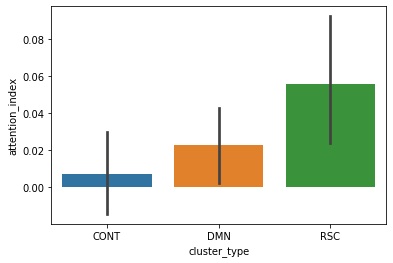

In [226]:
ps_attention = df.groupby(['cluster_type', 'sub_id']).mean().reset_index()
#AnovaRM(data=ps_attention, depvar='attention_index', subject='sub_id', within=['cluster_type']).fit())


#from bioinfokit.analys import stat
#res = stat()
res.anova_stat(df=ps_attention, res_var='attention_index', anova_model='attention_index ~ C(cluster_type)')
#res.anova_summary
res.tukey_summary

#fig = interaction_plot(x=df['conn_type'], trace=df['cond_type'], response=df['fc_measure'], colors=['#4c061d','#d17a22'])
#plt.show()
sns.barplot(x="cluster_type", y="attention_index", data=ps_attention)

In [229]:
#ttest_1samp(ps_attention.loc[ps_attention['cluster_type'] == 'CONT', 'attention_index'].tolist(), 0)
#ttest_1samp(ps_attention.loc[ps_attention['cluster_type'] == 'DMN', 'attention_index'].tolist(), 0)
ttest_ind(ps_attention.loc[ps_attention['cluster_type'] == 'RSC', 'attention_index'].tolist(),
          ps_attention.loc[ps_attention['cluster_type'] == 'DMN', 'attention_index'].tolist())

Ttest_indResult(statistic=1.5592948033558665, pvalue=0.1257808347805109)

In [219]:
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/allconds_epoch_labels_MVPA.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# a list of 16 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:

    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]

    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape

    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)

    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    # For each cluster, average ts across each epoch for each voxel. 
    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)

    within_state_ps_persub = []
    between_state_ps_persub = []

    for i in range(24):

        # get all 32 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]

        cond1_run1 = sub_raw_data_list[0:8] #(scramble)
        cond1_run2 = sub_raw_data_list[8:16] #(scramble)
        cond2_run1 = sub_raw_data_list[16:24] #(retrieve)
        cond2_run2 = sub_raw_data_list[24:32] #(retrieve)
        cond3_run1 = sub_raw_data_list[32:40] #(perceive)
        cond3_run2 = sub_raw_data_list[40:48] #(perceive)
        within_state_ps = []
        between_state_ps = []

        # compute within-attention state PS
        for eid, epoch in enumerate(sub_raw_data_list):
            if eid < 8: # cond1_run1 (scramble)
                #within_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond1_run2])/2 + 
                #                       np.mean([pearsonr(epoch, y)[0] for y in cond3_run1+cond3_run2])/2)
                within_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond1_run2+cond3_run1+cond3_run2]))
                between_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond2_run1+cond2_run2]))
            elif 8 <= eid < 16: # cond1_run2 (scramble)
                #within_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond1_run1])/2 + 
                #                       np.mean([pearsonr(epoch, y)[0] for y in cond3_run1+cond3_run2])/2)
                within_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond1_run1+cond3_run1+cond3_run2]))
                between_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond2_run1+cond2_run2]))
            elif 16 <= eid < 24: # cond2_run1 (retrieve)
                within_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond2_run2]))
                between_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond1_run1+cond1_run2+cond3_run1+cond3_run2]))
            elif 24 <= eid < 32: # cond2_run2 (retrieve)
                within_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond2_run1]))
                between_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond1_run1+cond1_run2+cond3_run1+cond3_run2]))
            elif 32 <= eid < 40: # cond3_run1 (perceive)
                #within_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond3_run2])/2 + 
                #                       np.mean([pearsonr(epoch, y)[0] for y in cond1_run1+cond1_run2])/2)
                within_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond3_run2+cond1_run1+cond1_run2]))
                between_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond2_run1+cond2_run2]))
            elif 40 <= eid < 48: # cond3_run2 (perceive)
                #within_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond3_run1])/2 + 
                #                       np.mean([pearsonr(epoch, y)[0] for y in cond1_run1+cond1_run2])/2)
                within_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond3_run1+cond1_run1+cond1_run2]))
                between_state_ps.append(np.mean([pearsonr(epoch, y)[0] for y in cond2_run1+cond2_run2]))

        within_state_ps_persub.append(within_state_ps)
        between_state_ps_persub.append(between_state_ps)

    within_state_ps_perROI.append(within_state_ps_persub)
    between_state_ps_perROI.append(between_state_ps_persub)

# ----------------------------
# Write CSV and save the data
# ----------------------------
df = pd.DataFrame(columns = ['sub_id','attention_state','epoch','within_state_ps','between_state_ps',"cluster"])
df['sub_id'] = np.repeat(range(1, num_subjs + 1), epochs_per_subj).tolist() * num_cluster
df['attention_state'] = np.repeat(['Scramble','Retrieve','Perceive'], epochs_per_subj/3).tolist() * num_subjs * num_cluster
df['epoch'] = np.arange(0, epochs_per_subj/3).tolist() * num_subjs * 3 * num_cluster
df['within_state_ps'] = np.arctanh(list(itertools.chain(*list(itertools.chain(*within_state_ps_perROI)))))
df['between_state_ps'] = np.arctanh(list(itertools.chain(*list(itertools.chain(*between_state_ps_perROI)))))
df['cluster'] = np.repeat(range(1, num_cluster + 1), num_subjs * epochs_per_subj)
df['cluster_type'] = np.repeat(roi_type, num_subjs * epochs_per_subj)

In [220]:
df['attention_idx'] = df['within_state_ps'] - df['between_state_ps']
df['cluster_type'] = np.repeat(roi_type, num_subjs * epochs_per_subj)
ps_attention = df.groupby(['cluster_type', 'sub_id'])['attention_idx'].mean().reset_index()

                   df    sum_sq   mean_sq         F    PR(>F)
C(cluster_type)   2.0  0.008059  0.004030  1.628863  0.203604
Residual         69.0  0.170696  0.002474       NaN       NaN


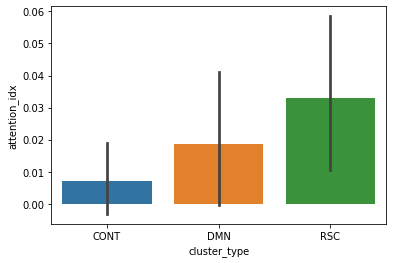

In [221]:
# ANOVA
res = stat()
res.anova_stat(df=ps_attention, res_var='attention_idx', anova_model='attention_idx ~ C(cluster_type)')
print(res.anova_summary)

# Post-hoc
#res = stat()
#res.tukey_hsd(df=ps_attention, res_var='attention_idx', xfac_var='cluster_type', anova_model='attention_idx ~ C(cluster_type)')
#print(res.tukey_summary)

#ps_task['cluster_type'] = ps_task['cluster_type'].astype("category")

sns.barplot(x="cluster_type", y="attention_idx", data=ps_attention)
#plt.show()

#ttest_1samp(ps_attention.loc[ps_attention['cluster_type'] == 'CONT', 'attention_idx'].tolist(), 0)
#ttest_1samp(ps_attention.loc[ps_attention['cluster_type'] == 'DMN', 'attention_idx'].tolist(), 0)

## Evoked response analyses for Task State (Exclude scramble condition). 

In [10]:
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/faceTask_sceneTask_epoch_lables.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    
    within_state_ps_persub = []
    between_state_ps_persub = []

    for i in range(24):

        # get all 32 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]

        # face epoch in 4 runs
        run1_face,run2_face,run3_face,run4_face = \
         sub_raw_data_list[0:4],sub_raw_data_list[4:8],sub_raw_data_list[8:12],sub_raw_data_list[12:16]
        
        # scene epoch in 4 runs
        run1_scene,run2_scene,run3_scene,run4_scene = \
         sub_raw_data_list[16:20],sub_raw_data_list[20:24],sub_raw_data_list[24:28],sub_raw_data_list[28:32]
            
        within_state_ps = []
        between_state_ps = []
        # compute within-attention state PS
        for eid, epoch in enumerate(sub_raw_data_list):
            # run1 Face TASK -- Cond1 
            if eid < 4:
                
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face])# different visual input from the other condition
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run3_face])# the same visual input cat as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2]))# balance the visual input from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run3_scene])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
            
            # run2 Face TASK -- Cond2
            elif 4 <= eid < 8:  
                                       
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face]) # different visual input from the other condition
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run4_face]) # the same visual input cat as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) # balance the visual input from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run4_scene])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
            
            # run3 Face TASK -- Cond1
            elif 8 <= eid < 12:
                                       
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face]) # different visual input from the other condition
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run1_face]) # the same visual input cat as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) # balance the visual input from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
            
            # run4 Face TASK
            elif 12 <= eid < 16:             
                                       
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face]) # different visual input from the other condition
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run2_face]) # the same visual input cat as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) # balance the visual input from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
            
            # run1 Scene TASK -- Cond1
            elif 16 <= eid < 20:
                
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene]) # different visual input from the other condition
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run3_scene]) # the same visual input cat as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) # balance the visual input from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run3_face])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
                                       
            # run2 Scene TASK -- Cond2
            elif 20 <= eid < 24:
                
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene]) # different visual input from the other condition
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run4_scene]) # the same visual input cat as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) # balance the visual input from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run4_face])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
                
            # run3 Scene TASK -- Cond1
            elif 24 <= eid < 28:
                
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene]) # different visual input from the other condition
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene]) # the same visual input cat as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) # balance the visual input from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run1_face])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
            
            # run4 Scene TASK -- Cond2
            elif 28 <= eid < 32:             
               
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene]) # different visual input from the other condition
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene]) # the same visual input cat as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) # balance the visual input from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run2_face])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))

        within_state_ps_persub.append(within_state_ps)
        between_state_ps_persub.append(between_state_ps)
    
    within_state_ps_perROI.append(within_state_ps_persub)
    between_state_ps_perROI.append(between_state_ps_persub)

    
# ----------------------------
# Write CSV and save the data
# ----------------------------
df = pd.DataFrame(columns = ['sub_id','epoch','task_state', 'within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.repeat(range(1, num_subjs + 1), epochs_per_subj).tolist() * num_cluster
df['task_state'] = np.repeat(['Face','Scene'],epochs_per_subj/2).tolist() * num_subjs * num_cluster
df['epoch'] = np.arange(0, epochs_per_subj/2).tolist() * num_subjs * 2 * num_cluster
df['within_state_ps'] = list(itertools.chain(*list(itertools.chain(*within_state_ps_perROI))))
df['between_state_ps'] = list(itertools.chain(*list(itertools.chain(*between_state_ps_perROI))))
df['cluster'] = np.repeat(range(1, num_cluster + 1), num_subjs * epochs_per_subj)

df.to_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/csv_outputs/cluster16_task_states_ps_result_BALANCED.csv')


In [110]:
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/faceTask_sceneTask_epoch_lables_ret_scramble.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    
    within_state_ps_persub = []
    between_state_ps_persub = []

    for i in range(24):

        # get all 32 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]

        # face epoch in 4 runs
        run1_face,run2_face,run3_face,run4_face = \
         sub_raw_data_list[0:4],sub_raw_data_list[4:8],sub_raw_data_list[8:12],sub_raw_data_list[12:16]
        
        # scene epoch in 4 runs
        run1_scene,run2_scene,run3_scene,run4_scene = \
         sub_raw_data_list[16:20],sub_raw_data_list[20:24],sub_raw_data_list[24:28],sub_raw_data_list[28:32]
            
        within_state_ps = []
        between_state_ps = []
        # compute within-attention state PS
        for eid, epoch in enumerate(sub_raw_data_list):
            # run1 Face TASK -- Cond1 
            if eid < 4:
                
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face])# different visual input from the other condition
                within_state_ps.append(within_ps)# balance the visual input from the other condition
                 
                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene])                  
                between_state_ps.append(between_ps)
            
            # run2 Face TASK -- Cond2
            elif 4 <= eid < 8:  
                                       
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face]) # different visual input from the other condition
                within_state_ps.append(within_ps) # balance the visual input from the other condition
                 
                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene])   
                between_state_ps.append(between_ps)
            
            # run3 Face TASK -- Cond1
            elif 8 <= eid < 12:
                                       
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face]) # different visual input from the other condition
                within_state_ps.append(within_ps) # balance the visual input from the other condition
                 
                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene])                      
                between_state_ps.append(between_ps)
            
            # run4 Face TASK
            elif 12 <= eid < 16:             
                                       
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face]) # different visual input from the other condition
                within_state_ps.append(within_ps) # balance the visual input from the other condition
                 
                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene])                    
                between_state_ps.append(between_ps)
            
            # run1 Scene TASK -- Cond1
            elif 16 <= eid < 20:
                
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene]) # different visual input from the other condition
                within_state_ps.append(within_ps) # balance the visual input from the other condition
                 
                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face])                 
                between_state_ps.append(between_ps)
                                       
            # run2 Scene TASK -- Cond2
            elif 20 <= eid < 24:
                
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene]) # different visual input from the other condition
                within_state_ps.append(within_ps) # balance the visual input from the other condition
                 
                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face])                    
                between_state_ps.append(between_ps)
                
            # run3 Scene TASK -- Cond1
            elif 24 <= eid < 28:
                
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene]) # different visual input from the other condition
                within_state_ps.append(within_ps) # balance the visual input from the other condition
                 
                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face])                   
                between_state_ps.append(between_ps)
            
            # run4 Scene TASK -- Cond2
            elif 28 <= eid < 32:             
               
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene]) # different visual input from the other condition
                within_state_ps.append(within_ps) # balance the visual input from the other condition
                 
                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face])                  
                between_state_ps.append(between_ps)

        within_state_ps_persub.append(within_state_ps)
        between_state_ps_persub.append(between_state_ps)
    
    within_state_ps_perROI.append(within_state_ps_persub)
    between_state_ps_perROI.append(between_state_ps_persub)

    
# ----------------------------
# Write CSV and save the data
# ----------------------------
df = pd.DataFrame(columns = ['sub_id','epoch','task_state', 'within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.repeat(range(1, num_subjs + 1), epochs_per_subj).tolist() * num_cluster
df['task_state'] = np.repeat(['Face','Scene'],epochs_per_subj/2).tolist() * num_subjs * num_cluster
df['epoch'] = np.arange(0, epochs_per_subj/2).tolist() * num_subjs * 2 * num_cluster
df['within_state_ps'] = list(itertools.chain(*list(itertools.chain(*within_state_ps_perROI))))
df['between_state_ps'] = list(itertools.chain(*list(itertools.chain(*between_state_ps_perROI))))
df['cluster'] = np.repeat(range(1, num_cluster + 1), num_subjs * epochs_per_subj)

#df.to_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/csv_outputs/cluster16_task_states_ps_result_across_ret_scramble.csv')


In [118]:
pearsonr(run_face[1],run2_face[0])

NameError: name 'run5_face' is not defined

## Task state (include scramble condition)

                   df    sum_sq   mean_sq         F   PR(>F)
C(cluster_type)   2.0  0.019389  0.009694  3.812284  0.02689
Residual         69.0  0.175464  0.002543       NaN      NaN
  group1 group2      Diff     Lower     Upper   q-value   p-value
0   CONT    DMN  0.005062 -0.013035  0.023160  0.947534  0.761504
1   CONT    RSC  0.035654  0.017556  0.053751  6.673606  0.001000
2    DMN    RSC  0.030591  0.012494  0.048689  5.726072  0.001000


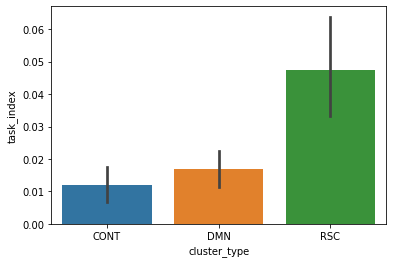

In [132]:
def compute_ps(run1, run2):
    """
    run1 and run2 are two lists, each is a list of 4 epochs 
    """
    ps = []
    for epoch in run1:
        ps.append(np.mean(np.arctang[pearsonr(epoch, y)[0] for y in run2]))
    ps_mean = np.mean(ps)
    return(ps_mean)
        
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/faceTask_sceneTask_epoch_lables_48epochs.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# get epoch identity (i.e., face/scene task under which condition )
epoch_identity = pd.read_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/epoch_and_labels/block_image_identity.csv')
faceTask_cond = epoch_identity.loc[epoch_identity['block'] == 'Face', 'condition'].tolist()
sceneTask_cond = epoch_identity.loc[epoch_identity['block'] == 'Scene', 'condition'].tolist()
epoch_dic = {}
for sub in range(num_subjs):
    epoch_start = epochs_per_subj*sub
    epoch_cond_start = int(epochs_per_subj/2*sub)
    epoch = epoch_info[epoch_start: epoch_start + epochs_per_subj]
    sub_faceTask_cond = faceTask_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    sub_sceneTask_cond = sceneTask_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    for e, cond in zip(epoch, sub_faceTask_cond + sub_sceneTask_cond):
        epoch_dic[e] = cond

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    
    within_state_ps_persub = []
    between_state_ps_persub = []

    for i in range(24):

        # get all 48 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]
        
        # identity for each block
        cond_identity = list(epoch_dic.values())[start_ind:end_ind]
        face_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(0,24,4))]
        scene_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(24,48,4))]
        
        # face epoch in 6 runs (each run has 4 face epochs)
        face = {}
        for idx, cond in enumerate(face_runs):
            start = 4*idx
            if idx < 3:
                face[f'{cond}_run1_face'] = sub_raw_data_list[start:start+4]
            else:
                face[f'{cond}_run2_face'] = sub_raw_data_list[start:start+4]
        
        # scene epoch in 6 runs (each run has 4 scene epochs)
        scene = {}
        for idx, cond in enumerate(scene_runs):
            start = 24 + 4*idx
            if idx < 3:
                scene[f'{cond}_run1_scene'] = sub_raw_data_list[start:start+4]
            else:
                scene[f'{cond}_run2_scene'] = sub_raw_data_list[start:start+4]
         
        # each subject
        within_state_ps_persub.append(np.mean([np.mean([compute_ps(face['Perceive_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run2_scene'])]),
                                            
                                               np.mean([compute_ps(face['Perceive_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['Retrieve_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['Retrieve_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['PerceiveScrambled_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['PerceiveScrambled_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run2_scene'])])]))
        # compute between- state PS
        between_state_ps_persub.append(np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run1_scene']),
                                                compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run2_scene']),
                                                compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run1_scene']),
                                                compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run2_scene']),
                                                compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run1_scene']),
                                                compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run2_scene']),
                                                compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run1_scene']),
                                                compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run2_scene']),
                                                compute_ps(face['Perceive_run1_face'], scene['Retrieve_run1_scene']),
                                                compute_ps(face['Perceive_run1_face'], scene['Retrieve_run2_scene']),
                                                compute_ps(face['Perceive_run2_face'], scene['Retrieve_run1_scene']),
                                                compute_ps(face['Perceive_run2_face'], scene['Retrieve_run2_scene']),
                                                compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run1_face']),
                                                compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run2_face']),
                                                compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run1_face']),
                                                compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run2_face']),
                                                compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run1_face']),
                                                compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run2_face']),
                                                compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run1_face']),
                                                compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run2_face']),
                                                compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run1_face']),
                                                compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run2_face']),
                                                compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run1_face']),
                                                compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run2_face']),
                                                compute_ps(face['PerceiveScrambled_run1_face'], scene['PerceiveScrambled_run2_scene']),
                                                compute_ps(face['Perceive_run1_face'], scene['Perceive_run2_scene']),
                                                compute_ps(face['Retrieve_run1_face'], scene['Retrieve_run2_scene'])]))
    # each ROI
    within_state_ps_perROI.append(within_state_ps_persub)
    between_state_ps_perROI.append(between_state_ps_persub)

# ----------------------------
# Write CSV and save the data
# ----------------------------
roi = ["mPFC","rAG","Precuneus(inferior)","lLOC","rLOC","Precuneus(Superior)","lAG1","rPFC","lPFC1",
       "PCC","Precuenus(Inferior)2","SFG","lPFC2","MTG","lAG2","rITG"]
roi_type = ['DMN','DMN','RSC','CONT','CONT','DMN','DMN','CONT','CONT','DMN','RSC','CONT','CONT',
            'DMN','DMN','CONT']
df = pd.DataFrame(columns = ['sub_id','within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.tile(range(1,25),num_cluster).tolist() 
df['within_state_ps'] = list(itertools.chain(*within_state_ps_perROI))
df['between_state_ps'] = list(itertools.chain(*between_state_ps_perROI))
df['cluster'] = np.repeat(roi, 24)
df['cluster_type'] = np.repeat(roi_type, 24)
df['task_index'] =  df['within_state_ps'] - df['between_state_ps']
ps_task = df.groupby(['cluster_type', 'sub_id']).mean().reset_index()

# ANOVA
ps_task = df.groupby(['cluster_type', 'sub_id']).mean().reset_index()
res = stat()
res.anova_stat(df=ps_attention, res_var='attention_index', anova_model='attention_index ~ C(cluster_type)')
print(res.anova_summary)

# Post-hoc
res = stat()
res.tukey_hsd(df=ps_task, res_var='task_index', xfac_var='cluster_type', anova_model='task_index ~ C(cluster_type)')
print(res.tukey_summary)

#ps_task['cluster_type'] = ps_task['cluster_type'].astype("category")

sns.barplot(x="cluster_type", y="task_index", data=ps_task)
#plt.show()

In [31]:
def compute_ps(run1, run2):
    """
    run1 and run2 are two lists, each is a list of 4 epochs 
    """
    ps = []
    for epoch in run1:
        ps.append(np.mean([pearsonr(epoch, y)[0] for y in run2]))
    ps_mean = np.mean(ps)
    return(ps_mean)
        
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/faceTask_sceneTask_epoch_lables_48epochs.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# get epoch identity (i.e., face/scene task under which condition )
epoch_identity = pd.read_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/epoch_and_labels/block_image_identity.csv')
faceTask_cond = epoch_identity.loc[epoch_identity['block'] == 'Face', 'condition'].tolist()
sceneTask_cond = epoch_identity.loc[epoch_identity['block'] == 'Scene', 'condition'].tolist()
epoch_dic = {}
for sub in range(num_subjs):
    epoch_start = epochs_per_subj*sub
    epoch_cond_start = int(epochs_per_subj/2*sub)
    epoch = epoch_info[epoch_start: epoch_start + epochs_per_subj]
    sub_faceTask_cond = faceTask_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    sub_sceneTask_cond = sceneTask_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    for e, cond in zip(epoch, sub_faceTask_cond + sub_sceneTask_cond):
        epoch_dic[e] = cond

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    
    within_state_ps_persub = []
    between_state_ps_persub = []

    for i in range(24):

        # get all 48 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]
        
        # identity for each block
        cond_identity = list(epoch_dic.values())[start_ind:end_ind]
        face_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(0,24,4))]
        scene_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(24,48,4))]
        
        # face epoch in 6 runs (each run has 4 face epochs)
        face = {}
        for idx, cond in enumerate(face_runs):
            start = 4*idx
            if idx < 3:
                face[f'{cond}_run1_face'] = sub_raw_data_list[start:start+4]
            else:
                face[f'{cond}_run2_face'] = sub_raw_data_list[start:start+4]
        
        # scene epoch in 6 runs (each run has 4 scene epochs)
        scene = {}
        for idx, cond in enumerate(scene_runs):
            start = 24 + 4*idx
            if idx < 3:
                scene[f'{cond}_run1_scene'] = sub_raw_data_list[start:start+4]
            else:
                scene[f'{cond}_run2_scene'] = sub_raw_data_list[start:start+4]
         
        # each subject
        within_state_ps_persub.append(np.mean([np.mean([compute_ps(face['Perceive_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run2_scene'])]),
                                            
                                               np.mean([compute_ps(face['Perceive_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['Retrieve_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['Retrieve_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['PerceiveScrambled_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['PerceiveScrambled_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run2_scene'])])]))
        # compute between- state PS
        between_state_ps_persub.append(np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run1_scene']),
                                                compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run2_scene']),
                                                compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run1_scene']),
                                                compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run2_scene']),
                                                compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run1_scene']),
                                                compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run2_scene']),
                                                compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run1_scene']),
                                                compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run2_scene']),
                                                compute_ps(face['Perceive_run1_face'], scene['Retrieve_run1_scene']),
                                                compute_ps(face['Perceive_run1_face'], scene['Retrieve_run2_scene']),
                                                compute_ps(face['Perceive_run2_face'], scene['Retrieve_run1_scene']),
                                                compute_ps(face['Perceive_run2_face'], scene['Retrieve_run2_scene']),
                                                compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run1_face']),
                                                compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run2_face']),
                                                compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run1_face']),
                                                compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run2_face']),
                                                compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run1_face']),
                                                compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run2_face']),
                                                compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run1_face']),
                                                compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run2_face']),
                                                compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run1_face']),
                                                compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run2_face']),
                                                compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run1_face']),
                                                compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run2_face']),
                                                compute_ps(face['PerceiveScrambled_run1_face'], scene['PerceiveScrambled_run2_scene']),
                                                compute_ps(face['Perceive_run1_face'], scene['Perceive_run2_scene']),
                                                compute_ps(face['Retrieve_run1_face'], scene['Retrieve_run2_scene'])]))
    # each ROI
    within_state_ps_perROI.append(within_state_ps_persub)
    between_state_ps_perROI.append(between_state_ps_persub)

# ----------------------------
# Write CSV and save the data
# ----------------------------
roi = ["mPFC","rAG","Precuneus(inferior)","lLOC","rLOC","Precuneus(Superior)","lAG1","rPFC","lPFC1",
       "PCC","Precuenus(Inferior)2","SFG","lPFC2","MTG","lAG2","rITG"]
roi_type = ['DMN','DMN','RSC','CONT','CONT','DMN','DMN','CONT','CONT','DMN','RSC','CONT','CONT',
            'DMN','DMN','CONT']
df = pd.DataFrame(columns = ['sub_id','within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.tile(range(1,25),num_cluster).tolist() 
df['within_state_ps'] = list(itertools.chain(*within_state_ps_perROI))
df['between_state_ps'] = list(itertools.chain(*between_state_ps_perROI))
df['cluster'] = np.repeat(roi, 24)
df['cluster_type'] = np.repeat(roi_type, 24)
df['task_index'] =  df['within_state_ps'] - df['between_state_ps']
ps_task = df.groupby(['cluster_type', 'sub_id']).mean().reset_index()

# ANOVA
res = stat()
res.anova_stat(df=task_attention, res_var='task_index', anova_model='task_index ~ C(cluster_type)')
print(res.anova_summary)

# Post-hoc
res = stat()
res.tukey_hsd(df=ps_task, res_var='task_index', xfac_var='cluster_type', anova_model='task_index ~ C(cluster_type)')
print(res.tukey_summary)

#ps_task['cluster_type'] = ps_task['cluster_type'].astype("category")

sns.barplot(x="cluster_type", y="task_index", data=ps_task)
#plt.show()

0     CONT
1     CONT
2     CONT
3     CONT
4     CONT
      ... 
67     RSC
68     RSC
69     RSC
70     RSC
71     RSC
Name: cluster_type, Length: 72, dtype: object

In [133]:
print(res.anova_summary)

                   df    sum_sq   mean_sq          F    PR(>F)
C(cluster_type)   2.0  0.017861  0.008931  13.037124  0.000016
Residual         69.0  0.047266  0.000685        NaN       NaN


In [134]:
print(res.tukey_summary)

  group1 group2      Diff     Lower     Upper   q-value   p-value
0   CONT    DMN  0.005062 -0.013035  0.023160  0.947534  0.761504
1   CONT    RSC  0.035654  0.017556  0.053751  6.673606  0.001000
2    DMN    RSC  0.030591  0.012494  0.048689  5.726072  0.001000


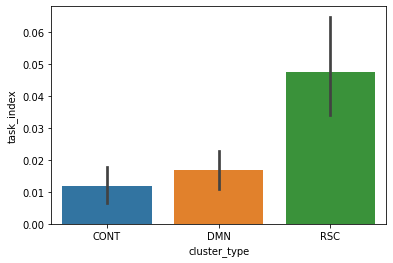

In [135]:
sns.barplot(x="cluster_type", y="task_index", data=ps_task)

                   df    sum_sq   mean_sq          F        PR(>F)
C(cluster_type)   2.0  0.123403  0.061701  29.603311  5.216545e-10
Residual         69.0  0.143815  0.002084        NaN           NaN
  group1 group2      Diff     Lower     Upper    q-value  p-value
0   CONT    DMN  0.026342 -0.005226  0.057910   2.826659  0.12031
1   CONT    RSC  0.071636  0.040068  0.103205   7.687079  0.00100
2    DMN    RSC  0.097978  0.066410  0.129546  10.513738  0.00100


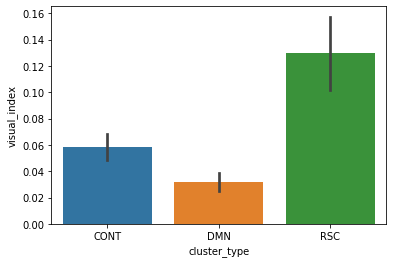

In [136]:
def compute_ps(run1, run2):
    """
    run1 and run2 are two lists, each is a list of 4 epochs 
    """
    ps = []
    for epoch in run1:
        ps.append(np.mean([pearsonr(epoch, y)[0] for y in run2]))
    ps_mean = np.mean(ps)
    return(ps_mean)
        
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/faceCue_sceneCue_epoch_lables_48epochs.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# get epoch identity (i.e., face/scene task under which condition )
epoch_identity = pd.read_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/epoch_and_labels/block_image_identity.csv')
faceTask_cond = epoch_identity.loc[epoch_identity['block'] == 'Face', 'condition'].tolist()
sceneTask_cond = epoch_identity.loc[epoch_identity['block'] == 'Scene', 'condition'].tolist()
epoch_dic = {}
for sub in range(num_subjs):
    epoch_start = epochs_per_subj*sub
    epoch_cond_start = int(epochs_per_subj/2*sub)
    epoch = epoch_info[epoch_start: epoch_start + epochs_per_subj]
    sub_faceTask_cond = faceTask_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    sub_sceneTask_cond = sceneTask_cond[epoch_cond_start: epoch_cond_start + int(epochs_per_subj/2)]
    for e, cond in zip(epoch, sub_faceTask_cond + sub_sceneTask_cond):
        epoch_dic[e] = cond

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    
    within_state_ps_persub = []
    between_state_ps_persub = []

    for i in range(24):

        # get all 48 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]
        
        # identity for each block
        cond_identity = list(epoch_dic.values())[start_ind:end_ind]
        face_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(0,24,4))]
        scene_runs = [np.unique(cond_identity[start:start+4])[0] for start in list(np.arange(24,48,4))]
        
        # face epoch in 6 runs (each run has 4 face epochs)
        face = {}
        for idx, cond in enumerate(face_runs):
            start = 4*idx
            if idx < 3:
                face[f'{cond}_run1_face'] = sub_raw_data_list[start:start+4]
            else:
                face[f'{cond}_run2_face'] = sub_raw_data_list[start:start+4]
        
        # scene epoch in 6 runs (each run has 4 scene epochs)
        scene = {}
        for idx, cond in enumerate(scene_runs):
            start = 24 + 4*idx
            if idx < 3:
                scene[f'{cond}_run1_scene'] = sub_raw_data_list[start:start+4]
            else:
                scene[f'{cond}_run2_scene'] = sub_raw_data_list[start:start+4]
         
        # each subject
        within_state_ps_persub.append(np.mean([np.mean([compute_ps(face['Perceive_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['Perceive_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['Perceive_run2_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Retrieve_run2_scene'])]),
                                            
                                               np.mean([compute_ps(face['Perceive_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['Retrieve_run1_face'], face['Retrieve_run2_face']),
                                               compute_ps(scene['Perceive_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['Retrieve_run1_scene'], scene['Retrieve_run2_scene']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run1_face']),
                                               compute_ps(face['PerceiveScrambled_run2_face'], face['Perceive_run2_face']),
                                               compute_ps(face['PerceiveScrambled_run1_face'], face['PerceiveScrambled_run2_face']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['PerceiveScrambled_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run1_scene'], scene['Perceive_run2_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run1_scene']),
                                               compute_ps(scene['PerceiveScrambled_run2_scene'], scene['Perceive_run2_scene'])])]))
        # compute between- state PS
        between_state_ps_persub.append(np.mean([compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run1_scene']),
                                                compute_ps(face['PerceiveScrambled_run1_face'], scene['Retrieve_run2_scene']),
                                                compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run1_scene']),
                                                compute_ps(face['PerceiveScrambled_run2_face'], scene['Retrieve_run2_scene']),
                                                compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run1_scene']),
                                                compute_ps(face['PerceiveScrambled_run1_face'], scene['Perceive_run2_scene']),
                                                compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run1_scene']),
                                                compute_ps(face['PerceiveScrambled_run2_face'], scene['Perceive_run2_scene']),
                                                compute_ps(face['Perceive_run1_face'], scene['Retrieve_run1_scene']),
                                                compute_ps(face['Perceive_run1_face'], scene['Retrieve_run2_scene']),
                                                compute_ps(face['Perceive_run2_face'], scene['Retrieve_run1_scene']),
                                                compute_ps(face['Perceive_run2_face'], scene['Retrieve_run2_scene']),
                                                compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run1_face']),
                                                compute_ps(scene['PerceiveScrambled_run1_scene'], face['Retrieve_run2_face']),
                                                compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run1_face']),
                                                compute_ps(scene['PerceiveScrambled_run2_scene'], face['Retrieve_run2_face']),
                                                compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run1_face']),
                                                compute_ps(scene['PerceiveScrambled_run1_scene'], face['Perceive_run2_face']),
                                                compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run1_face']),
                                                compute_ps(scene['PerceiveScrambled_run2_scene'], face['Perceive_run2_face']),
                                                compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run1_face']),
                                                compute_ps(scene['Perceive_run1_scene'], face['Retrieve_run2_face']),
                                                compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run1_face']),
                                                compute_ps(scene['Perceive_run2_scene'], face['Retrieve_run2_face']),
                                                compute_ps(face['PerceiveScrambled_run1_face'], scene['PerceiveScrambled_run2_scene']),
                                                compute_ps(face['Perceive_run1_face'], scene['Perceive_run2_scene']),
                                                compute_ps(face['Retrieve_run1_face'], scene['Retrieve_run2_scene'])]))
    # each ROI
    within_state_ps_perROI.append(within_state_ps_persub)
    between_state_ps_perROI.append(between_state_ps_persub)

# ----------------------------
# Write CSV and save the data
# ----------------------------
roi = ["mPFC","rAG","Precuneus(inferior)","lLOC","rLOC","Precuneus(Superior)","lAG1","rPFC","lPFC1",
       "PCC","Precuenus(Inferior)2","SFG","lPFC2","MTG","lAG2","rITG"]
roi_type = ['DMN','DMN','RSC','CONT','CONT','DMN','DMN','CONT','CONT','DMN','RSC','CONT','CONT',
            'DMN','DMN','CONT']
df = pd.DataFrame(columns = ['sub_id','within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.tile(range(1,25),num_cluster).tolist() 
df['within_state_ps'] = list(itertools.chain(*within_state_ps_perROI))
df['between_state_ps'] = list(itertools.chain(*between_state_ps_perROI))
df['cluster'] = np.repeat(roi, 24)
df['cluster_type'] = np.repeat(roi_type, 24)
df['visual_index'] =  df['within_state_ps'] - df['between_state_ps']
ps_visual = df.groupby(['cluster_type', 'sub_id']).mean().reset_index()

# ANOVA
res = stat()
res.anova_stat(df=ps_visual, res_var='visual_index', anova_model='visual_index ~ C(cluster_type)')
print(res.anova_summary)

# Post-hoc
res = stat()
res.tukey_hsd(df=ps_visual, res_var='visual_index', xfac_var='cluster_type', anova_model='visual_index ~ C(cluster_type)')
print(res.tukey_summary)

#ps_task['cluster_type'] = ps_task['cluster_type'].astype("category")

sns.barplot(x="cluster_type", y="visual_index", data=ps_visual)
#plt.show()

In [ ]:


# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = []  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    
    within_state_ps_persub = []
    between_state_ps_persub = []

    for i in range(24):

        # get all 32 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]

        # face epoch in 4 runs
        run1_face,run2_face,run3_face,run4_face = \
         sub_raw_data_list[0:4],sub_raw_data_list[4:8],sub_raw_data_list[8:12],sub_raw_data_list[12:16]
        
        # scene epoch in 4 runs
        run1_scene,run2_scene,run3_scene,run4_scene = \
         sub_raw_data_list[16:20],sub_raw_data_list[20:24],sub_raw_data_list[24:28],sub_raw_data_list[28:32]
            
        within_state_ps = []
        between_state_ps = []
        # compute within-attention state PS
        for eid, epoch in enumerate(sub_raw_data_list):
            # run1 Face TASK -- Cond1 
            if eid < 4:
                
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face])# different visual input from the other condition
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run3_face])# the same visual input cat as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2]))# balance the visual input from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run3_scene])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
            
            # run2 Face TASK -- Cond2
            elif 4 <= eid < 8:  
                                       
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face]) # different visual input from the other condition
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run4_face]) # the same visual input cat as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) # balance the visual input from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run4_scene])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
            
            # run3 Face TASK -- Cond1
            elif 8 <= eid < 12:
                                       
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face]) # different visual input from the other condition
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run1_face]) # the same visual input cat as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) # balance the visual input from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
            
            # run4 Face TASK
            elif 12 <= eid < 16:             
                                       
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face]) # different visual input from the other condition
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run2_face]) # the same visual input cat as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) # balance the visual input from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
            
            # run1 Scene TASK -- Cond1
            elif 16 <= eid < 20:
                
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene]) # different visual input from the other condition
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run3_scene]) # the same visual input cat as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) # balance the visual input from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run3_face])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
                                       
            # run2 Scene TASK -- Cond2
            elif 20 <= eid < 24:
                
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene]) # different visual input from the other condition
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run4_scene]) # the same visual input cat as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) # balance the visual input from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run4_face])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
                
            # run3 Scene TASK -- Cond1
            elif 24 <= eid < 28:
                
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene]) # different visual input from the other condition
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene]) # the same visual input cat as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) # balance the visual input from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run1_face])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
            
            # run4 Scene TASK -- Cond2
            elif 28 <= eid < 32:             
               
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene]) # different visual input from the other condition
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene]) # the same visual input cat as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) # balance the visual input from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run2_face])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))

        within_state_ps_persub.append(within_state_ps)
        between_state_ps_persub.append(between_state_ps)
    
    within_state_ps_perROI.append(within_state_ps_persub)
    between_state_ps_perROI.append(between_state_ps_persub)

    
# ----------------------------
# Write CSV and save the data
# ----------------------------
df = pd.DataFrame(columns = ['sub_id','epoch','task_state', 'within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.repeat(range(1, num_subjs + 1), epochs_per_subj).tolist() * num_cluster
df['task_state'] = np.repeat(['Face','Scene'],epochs_per_subj/2).tolist() * num_subjs * num_cluster
df['epoch'] = np.arange(0, epochs_per_subj/2).tolist() * num_subjs * 2 * num_cluster
df['within_state_ps'] = list(itertools.chain(*list(itertools.chain(*within_state_ps_perROI))))
df['between_state_ps'] = list(itertools.chain(*list(itertools.chain(*between_state_ps_perROI))))
df['cluster'] = np.repeat(range(1, num_cluster + 1), num_subjs * epochs_per_subj)

df.to_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/csv_outputs/cluster16_task_states_ps_result_BALANCED.csv')


## Evoked response analyses for Visual State (Exclude scramble condition). 

In [11]:
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/faceCue_sceneCue_epoch_lables.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = [0]  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    
    within_state_ps_persub = []
    between_state_ps_persub = []

    for i in range(24):

        # get all 32 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]

        # face epoch in 4 runs
        run1_face,run2_face,run3_face,run4_face = \
         sub_raw_data_list[0:4],sub_raw_data_list[4:8],sub_raw_data_list[8:12],sub_raw_data_list[12:16]
        
        # scene epoch in 4 runs
        run1_scene,run2_scene,run3_scene,run4_scene = \
         sub_raw_data_list[16:20],sub_raw_data_list[20:24],sub_raw_data_list[24:28],sub_raw_data_list[28:32]
            
        within_state_ps = []
        between_state_ps = []
        # compute within-attention state PS
        for eid, epoch in enumerate(sub_raw_data_list):
            # run1 Face CUE -- Cond1
            if eid < 4:
                
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face])# different task state from run1-Face
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run3_face]) # the same task as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) # balance the task states from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run3_scene])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
            
            # run2 Face Cue -- Cond2
            elif 4 <= eid < 8:  
                                       
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face]) 
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run4_face]) 
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) 
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run4_scene])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
            
            # run3 Face Cue -- Cond1
            elif 8 <= eid < 12:
                                       
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face]) 
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run1_face]) 
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) 
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
            
            # run4 Face Cue --Cond2
            elif 12 <= eid < 16:             
                                       
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face]) 
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run2_face]) 
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) 
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
            
            # run1 Scene Cue -- Cond1
            elif 16 <= eid < 20:
                
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene]) # different task state from run1-Face
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run3_scene]) # the same task as run1-Face
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) # balance the task states from the other condition
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run3_face])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
                                       
            # run2 Scene Cue -- Cond2
            elif 20 <= eid < 24:
                
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene]) 
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run4_scene]) 
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) 
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run4_face])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
                
            # run3 Scene Cue -- Cond1
            elif 24 <= eid < 28:
                
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene]) 
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene])
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) 
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run1_face])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))
            
            # run4 Scene Cue -- Cond2
            elif 28 <= eid < 32:             
               
                within_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene]) 
                within_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run2_scene]) 
                within_state_ps.append(np.mean([within_ps1,  within_ps2])) 
                 
                between_ps1 = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face])
                between_ps2 = np.mean([pearsonr(epoch, y)[0] for y in run2_face])                      
                between_state_ps.append(np.mean([between_ps1,  between_ps2]))

        within_state_ps_persub.append(within_state_ps)
        between_state_ps_persub.append(between_state_ps)
    
    within_state_ps_perROI.append(within_state_ps_persub)
    between_state_ps_perROI.append(between_state_ps_persub)

    
# ----------------------------
# Write CSV and save the data
# ----------------------------
df = pd.DataFrame(columns = ['sub_id','epoch','visual_state','within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.repeat(range(1, num_subjs + 1), epochs_per_subj).tolist() * num_cluster
df['visual_state'] = np.repeat(['Face','Scene'],epochs_per_subj/2).tolist() * num_subjs * num_cluster
df['epoch'] = np.arange(0, epochs_per_subj/2).tolist() * num_subjs * 2 * num_cluster
df['within_state_ps'] = list(itertools.chain(*list(itertools.chain(*within_state_ps_perROI))))
df['between_state_ps'] = list(itertools.chain(*list(itertools.chain(*between_state_ps_perROI))))
df['cluster'] = np.repeat(range(1, num_cluster + 1), num_subjs * epochs_per_subj)

df.to_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/csv_outputs/cluster16_visual_states_ps_result_BALANCED.csv')


In [44]:
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/faceCue_sceneCue_epoch_lables.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
within_state_ps_perROI = []
between_state_ps_perROI = []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = [0]  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    
    within_state_ps_persub = []
    between_state_ps_persub = []

    for i in range(24):

        # get all 32 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]

        # face epoch in 4 runs
        run1_face,run2_face,run3_face,run4_face = \
         sub_raw_data_list[0:4],sub_raw_data_list[4:8],sub_raw_data_list[8:12],sub_raw_data_list[12:16]
        
        # scene epoch in 4 runs
        run1_scene,run2_scene,run3_scene,run4_scene = \
         sub_raw_data_list[16:20],sub_raw_data_list[20:24],sub_raw_data_list[24:28],sub_raw_data_list[28:32]
            
        within_state_ps = []
        between_state_ps = []
        # compute within-attention state PS
        for eid, epoch in enumerate(sub_raw_data_list):
            # run1 Face TASK -- Cond1 
            if eid < 4:
                
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face])# different visual input from the other condition
                within_state_ps.append(within_ps)# balance the visual input from the other condition
                 
                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene])                  
                between_state_ps.append(between_ps)
            
            # run2 Face TASK -- Cond2
            elif 4 <= eid < 8:  
                                       
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face]) # different visual input from the other condition
                within_state_ps.append(within_ps) # balance the visual input from the other condition
                 
                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene])   
                between_state_ps.append(between_ps)
            
            # run3 Face TASK -- Cond1
            elif 8 <= eid < 12:
                                       
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face]) # different visual input from the other condition
                within_state_ps.append(within_ps) # balance the visual input from the other condition
                 
                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene])                      
                between_state_ps.append(between_ps)
            
            # run4 Face TASK
            elif 12 <= eid < 16:             
                                       
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face]) # different visual input from the other condition
                within_state_ps.append(within_ps) # balance the visual input from the other condition
                 
                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene])                    
                between_state_ps.append(between_ps)
            
            # run1 Scene TASK -- Cond1
            elif 16 <= eid < 20:
                
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene]) # different visual input from the other condition
                within_state_ps.append(within_ps) # balance the visual input from the other condition
                 
                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face])                 
                between_state_ps.append(between_ps)
                                       
            # run2 Scene TASK -- Cond2
            elif 20 <= eid < 24:
                
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene]) # different visual input from the other condition
                within_state_ps.append(within_ps) # balance the visual input from the other condition
                 
                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face])                    
                between_state_ps.append(between_ps)
                
            # run3 Scene TASK -- Cond1
            elif 24 <= eid < 28:
                
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_scene + run4_scene]) # different visual input from the other condition
                within_state_ps.append(within_ps) # balance the visual input from the other condition
                 
                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_face + run4_face])                   
                between_state_ps.append(between_ps)
            
            # run4 Scene TASK -- Cond2
            elif 28 <= eid < 32:             
               
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_scene + run3_scene]) # different visual input from the other condition
                within_state_ps.append(within_ps) # balance the visual input from the other condition
                 
                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_face + run3_face])                  
                between_state_ps.append(between_ps)

        within_state_ps_persub.append(within_state_ps)
        between_state_ps_persub.append(between_state_ps)
    
    within_state_ps_perROI.append(within_state_ps_persub)
    between_state_ps_perROI.append(between_state_ps_persub)

    
# ----------------------------
# Write CSV and save the data
# ----------------------------
df = pd.DataFrame(columns = ['sub_id','epoch','visual_state','within_state_ps','between_state_ps','cluster'])
df['sub_id'] = np.repeat(range(1, num_subjs + 1), epochs_per_subj).tolist() * num_cluster
df['visual_state'] = np.repeat(['Face','Scene'],epochs_per_subj/2).tolist() * num_subjs * num_cluster
df['epoch'] = np.arange(0, epochs_per_subj/2).tolist() * num_subjs * 2 * num_cluster
df['within_state_ps'] = list(itertools.chain(*list(itertools.chain(*within_state_ps_perROI))))
df['between_state_ps'] = list(itertools.chain(*list(itertools.chain(*between_state_ps_perROI))))
df['cluster'] = np.repeat(range(1, num_cluster + 1), num_subjs * epochs_per_subj)

df.to_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/csv_outputs/cluster16_visual_states_ps_result_only_across_condition.csv')


## Check Task and Visual state sensitivity during perception, retrieval and scramble seperately. 

In [3]:
# get face/scene visual epoch for each of the three conditions: 
def combine_epochs(attn_epoch, cond2_epoch):
    bool_idx = []
    for attn_e in attn_epoch: 
        bool_idx.append(any([attn_e[1:4] == epoch[1:4] for epoch in cond2_epoch]))
    # the shared epoch of the given attention state and cond2
    shared_epoch = list(compress(attn_epoch, bool_idx))
    return shared_epoch
# ----------------------
# Attention conditions: 
# ----------------------
# load in epoch file
epoch_file_attn_conds = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/allconds_epoch_labels_MVPA.npy'
epoch_info_attns_conds = generate_epochs_info(io.load_labels(epoch_file_attn_conds)) # scramble; retrieve; perceive 

# the boolean index for each attention conditions
scramble_bool, ret_bool, per_bool = [epochs[0] == 0 for epochs in epoch_info_attns_conds], \
[epochs[0] == 1 for epochs in epoch_info_attns_conds], [epochs[0] == 2 for epochs in epoch_info_attns_conds]

# extract epoch for each attention condition: 
scramble_epoch, ret_epoch, per_epoch = list(compress(epoch_info_attns_conds, scramble_bool)), \
list(compress(epoch_info_attns_conds, ret_bool)), list(compress(epoch_info_attns_conds, per_bool))

# ------------------
# Visual conditions: 
# ------------------
epoch_file_visual_conds = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/faceCue_sceneCue_epoch_lables_48epochs.npy'
epoch_info_visual_conds = generate_epochs_info(io.load_labels(epoch_file_visual_conds)) # face; scene

# the boolean index for each visual condition: 
faceVis_bool, sceneVis_bool = [epochs[0] == 0 for epochs in epoch_info_visual_conds], [epochs[0] == 1 for epochs in epoch_info_visual_conds]
# extract epoch for each attention condition:
faceVis_epoch, sceneVis_epoch = list(compress(epoch_info_visual_conds, faceVis_bool)), list(compress(epoch_info_visual_conds, sceneVis_bool))

scramble_faceVis, scramble_sceneVis = combine_epochs(scramble_epoch, faceVis_epoch), combine_epochs(scramble_epoch, sceneVis_epoch)
ret_faceVis, ret_sceneVis = combine_epochs(ret_epoch, faceVis_epoch), combine_epochs(ret_epoch, sceneVis_epoch)
per_faceVis, per_sceneVis = combine_epochs(per_epoch, faceVis_epoch), combine_epochs(per_epoch, sceneVis_epoch)
            
# ------------------
# Task conditions: 
# ------------------
epoch_file_task_conds = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/faceTask_sceneTask_epoch_lables_48epochs.npy'
epoch_info_task_conds = generate_epochs_info(io.load_labels(epoch_file_task_conds)) # face; scene

# the boolean index for each task condition: 
faceTask_bool, sceneTask_bool = [epochs[0] == 0 for epochs in epoch_info_task_conds], [epochs[0] == 1 for epochs in epoch_info_task_conds]
# extract epoch for each attention condition:
faceTask_epoch, sceneTask_epoch = list(compress(epoch_info_task_conds, faceTask_bool)), list(compress(epoch_info_task_conds, sceneTask_bool))

scramble_faceTask, scramble_sceneTask = combine_epochs(scramble_epoch, faceTask_epoch), combine_epochs(scramble_epoch, sceneTask_epoch)
ret_faceTask, ret_sceneTask = combine_epochs(ret_epoch, faceTask_epoch), combine_epochs(ret_epoch, sceneTask_epoch)
per_faceTask, per_sceneTask = combine_epochs(per_epoch, faceTask_epoch), combine_epochs(per_epoch, sceneTask_epoch)

In [9]:
def preprocess_with_epoch(act_data, epoch_info):
    
    # number of epochs
    num_epochs = len(epoch_info)
    
    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape
    
    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    # get ready for the loop
    subject_count = [0]  # counting the epochs per subject for z-scoring
    cur_sid = -1
    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)
    return processed_data

def compute_within_between_ps_all_sub(cond_face_evoked_ts, cond_scene_evoked_ts, epochs_per_subj):
    
    within_state_ps_persub = []
    between_state_ps_persub = []
    
    for i in range(24):

        # get all 32 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        
        # face and scene epochs for the current subject, 8 for each, 16 in total
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data_faceTask, sub_raw_data_sceneTask = cond_face_evoked_ts[:,start_ind:end_ind], cond_scene_evoked_ts[:,start_ind:end_ind]
        sub_raw_data_faceTask_list = [sub_raw_data_faceTask[:,i] for i in range(epochs_per_subj)]
        sub_raw_data_sceneTask_list = [sub_raw_data_sceneTask[:,i] for i in range(epochs_per_subj)]
        
        # combine face and scene epochs for each subject 
        sub_ret_face_scene_16_epochs = sub_raw_data_faceTask_list + sub_raw_data_sceneTask_list 

        # run structure for face and scene epochs
        run1_face,run2_face = \
            sub_raw_data_faceTask_list[0:4],sub_raw_data_faceTask_list[4:8]
        run1_scene,run2_scene = \
            sub_raw_data_sceneTask_list[0:4],sub_raw_data_sceneTask_list[4:8]
        
        # loop through each epoch, compute the within and between state ps for the given epoch 
        within_state_ps = []
        between_state_ps = []

        for eid, epoch in enumerate(sub_ret_face_scene_16_epochs):
            if eid < 4: # run1 Face Task -- 
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_face])
                within_state_ps.append(within_ps) 

                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_scene])           
                between_state_ps.append(between_ps)
            elif 4 <= eid < 8: # run2 Face Task -- 
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_face])
                within_state_ps.append(within_ps) 

                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_scene])           
                between_state_ps.append(between_ps)
            elif 8 <= eid < 12: # run1 Scene Task
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_scene])
                within_state_ps.append(within_ps) 

                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run2_face])           
                between_state_ps.append(between_ps)
            elif 12 <= eid < 16: # run2 Scene Task
                within_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_scene])
                within_state_ps.append(within_ps) 

                between_ps = np.mean([pearsonr(epoch, y)[0] for y in run1_face])           
                between_state_ps.append(between_ps)
        
        within_state_ps_persub.append(within_state_ps)
        between_state_ps_persub.append(between_state_ps)
        
    return within_state_ps_persub, between_state_ps_persub



In [10]:
# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# a list of 8 masks, each mask is a list of 24 subject, each subject is a list of 32 epoch, each epoch is a list of its PS with other Epcohs
RET_within_state_ps_ROI, RET_between_state_ps_ROI = [], []
PER_within_state_ps_ROI, PER_between_state_ps_ROI = [], []
for act_npy in clusters:
    
    # read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]
    
    # ------------------
    # Retrieve Condition
    # ------------------
    # get the evoked response time series for each epoch
    ret_faceTask_evoked_ts = preprocess_with_epoch(activity_data, ret_faceVis)
    ret_sceneTask_evoked_ts = preprocess_with_epoch(activity_data, ret_sceneVis)

    ret_roi_sub_epoch_withinps, ret_roi_sub_epoch_betweenps = compute_within_between_ps_all_sub(ret_faceTask_evoked_ts, ret_sceneTask_evoked_ts, 8)
    RET_within_state_ps_ROI.append(ret_roi_sub_epoch_withinps)
    RET_between_state_ps_ROI.append(ret_roi_sub_epoch_betweenps)
    
    # ------------------
    # Perceive Condition
    # ------------------
    # get the evoked response time series for each epoch
    per_faceTask_evoked_ts = preprocess_with_epoch(activity_data, per_faceVis)
    per_sceneTask_evoked_ts = preprocess_with_epoch(activity_data, per_sceneVis)
    
    per_roi_sub_epoch_withinps, per_roi_sub_epoch_betweenps = compute_within_between_ps_all_sub(per_faceTask_evoked_ts, per_sceneTask_evoked_ts, 8)
    PER_within_state_ps_ROI.append(per_roi_sub_epoch_withinps)
    PER_between_state_ps_ROI.append(per_roi_sub_epoch_betweenps)


In [11]:
Ret_diff_mean = np.mean(np.array(RET_within_state_ps_ROI) - np.array(RET_between_state_ps_ROI), axis = 2)
Per_diff_mean = np.mean(np.array(PER_within_state_ps_ROI) - np.array(PER_between_state_ps_ROI), axis = 2)

In [12]:
for i in range(16):
    ttest = ttest_rel(Ret_diff_mean[i,:], Per_diff_mean[i,:])
    print(ttest[0])

0.21334594512111077
-1.4403711910417454
-5.338495283666234
-1.6184645483289666
-1.078261260197646
-3.23809501396474
-0.8531433128366644
-2.1476086406990764
-3.0637202094389355
-1.5831755307920292
-4.830855541721636
-0.9420933471881268
-1.9353760647491547
-1.0864014625899636
-0.0809309242868878
-0.7195973073043587


In [42]:
for i in range(16):
    ttest = ttest_ind(Ret_diff_mean[i,:], Per_diff_mean[i,:])
    print(ttest[0])

0.24435354330824208
-1.4634583836904782
-5.474776436101156
-1.7329650374136545
-0.8324861238601601
-2.8219967939402246
-0.6734379690251209
-2.073824081672658
-3.2473205821168234
-1.579759374069198
-3.7335757900519786
-0.9685474167784126
-1.9649730195159085
-0.8726498620172606
-0.08503731886452395
-0.3914907037418525


In [27]:
 # get the evoked response time series for each epoch

a,b = \
compute_within_between_ps_all_sub(preprocess_with_epoch(activity_data, ret_faceVis), preprocess_with_epoch(activity_data, ret_sceneVis), 8)

In [28]:
c,d = \
compute_within_between_ps_all_sub(preprocess_with_epoch(activity_data, ret_faceTask), preprocess_with_epoch(activity_data, ret_sceneTask), 8)

In [38]:
np.mean(np.array(a) - np.array(b), axis = 1)

array([0.07843661, 0.15284875, 0.12126274, 0.45785461, 0.0687447 ,
       0.14511213, 0.64056645, 0.39840609, 0.30521894, 0.15068882,
       0.14105461, 0.01723118, 0.20792112, 0.08969179, 0.0224592 ,
       0.0598752 , 0.33191337, 0.14631985, 0.13742556, 0.13397602,
       0.04089725, 0.2941618 , 0.02406059, 0.38287663])

In [39]:
np.mean(np.array(c) - np.array(d), axis = 1)

array([0.07843661, 0.15284875, 0.12126274, 0.45785461, 0.0687447 ,
       0.14511213, 0.64056645, 0.39840609, 0.30521894, 0.15068882,
       0.14105461, 0.01723118, 0.20792112, 0.08969179, 0.0224592 ,
       0.0598752 , 0.33191337, 0.14631985, 0.13742556, 0.13397602,
       0.04089725, 0.2941618 , 0.02406059, 0.38287663])

### Evoked response MVPA analyses for each ROI

In [77]:
def _prepare_mvpa_data(roi_activity_data, epoch_info, epochs_per_subj):
    
    num_epochs = len(epoch_info)
    (d1, _) = roi_activity_data[0].shape # number of voxels in this roi
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)
    
    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0] # 1 or 0, perceive or retrieve
        cur_sid = epoch[1]
        processed_data[:, idx] = np.mean(roi_activity_data[cur_sid][:, epoch[2]:epoch[3]], axis = 1)
    
    for i in range(24):
        start_epoch = i*epochs_per_subj
        end_epoch = start_epoch + epochs_per_subj
        processed_data[:, start_epoch:end_epoch] = \
                zscore(processed_data[:, start_epoch:end_epoch],
                       axis=1, ddof=0)
    processed_data = np.nan_to_num(processed_data)
    
    return processed_data, labels

# train the classifier to differentiate between the two conditions:

def _extract_mvpa_clf_acc_conf(sid,processed_data,labels,epochs_per_subj,roi, condition):
    
    # what indexes pick out the left out participants? 
    start_idx = int(sid * epochs_per_subj)
    end_idx = int(start_idx + epochs_per_subj)
    
    # take out the idx corresponding to all participants but this one
    training_idx = list(set(range(len(labels))) - set(range(start_idx, end_idx)))
    testing_idx = list(range(start_idx, end_idx))
    
    # pull out the data
    processed_data_training = [processed_data[:,i] for i in training_idx]
    processed_data_testing = [processed_data[:,i] for i in testing_idx]
    
    # pull out the labels 
    labels_training = [labels[i] for i in training_idx]
    labels_testing = [labels[i] for i in testing_idx]
    
    # create model 
    svm_clf = SVC(kernel = 'linear',C=1, decision_function_shape = 'ovo')
    
    # train the model
    svm_clf.fit(processed_data_training, labels_training)
    
    # test the model
    predict = svm_clf.predict(processed_data_testing)
    corr = np.sum(predict == labels_testing)
    score = svm_clf.score(processed_data_testing, labels_testing)
    clf_conf = svm_clf.decision_function(processed_data_testing)
    
    if epochs_per_subj == 32 or epochs_per_subj == 16:
        df = pd.DataFrame(columns = ['subject_id','epoch_conf','clf_acc','roi','condition'])
        df['subject_id'] = np.repeat(sid + 1, len(clf_conf))
        df['epoch_conf'] = clf_conf
        df['clf_acc'] = np.repeat(score, len(clf_conf))
        df['roi'] = np.repeat(roi, len(clf_conf))
        df['condition'] = np.repeat(condition, len(clf_conf))

    return df

def extract_ROI_evoked_pattern_mvpa_info(ROI_subvoxTR, epoch, epochs_per_subj, roi, condition):
    
    from brainiak.fcma.preprocessing import generate_epochs_info
    # get epoch info 
    epoch_list = np.load(epoch)
    epoch_info = generate_epochs_info(epoch_list)
    
    # get processed_data (nVoxel, nEpoch)
    ROI_evoked = np.load(ROI_subvoxTR)
    processed_data, labels = _prepare_mvpa_data([ROI_evoked[sid,:,:] for sid in range(24)], epoch_info, epochs_per_subj)
    
    # run mvpa write into a df
    df = pd.concat([_extract_mvpa_clf_acc_conf(sid, processed_data, labels, epochs_per_subj, roi, condition) for sid in range(24)]).reset_index(drop=True)
    
    return df


# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# MVPA result for Attentional State
epoch_file_attn = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/perceive_retrieve_epoch_labels_MVPA.npy'
df = []
for roi, activity_mat in enumerate(clusters):
    if isinstance(df, pd.core.frame.DataFrame):
        df = pd.concat([df, extract_ROI_evoked_pattern_mvpa_info(activity_mat, epoch_file_attn, 32, roi, "Attention-state")]).reset_index(drop=True)
    else: 
        df = extract_ROI_evoked_pattern_mvpa_info(activity_mat, epoch_file_attn, 32, roi, "Attention-state")

# MVPA result for Task State
epoch_file_task = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/faceTask_sceneTask_epoch_lables.npy'
for roi, activity_mat in enumerate(clusters):
    if isinstance(df, pd.core.frame.DataFrame):
        df = pd.concat([df, extract_ROI_evoked_pattern_mvpa_info(activity_mat, epoch_file_task, 32, roi, "Task-state")]).reset_index(drop=True)
    else: 
        df = extract_ROI_evoked_pattern_mvpa_info(activity_mat, epoch_file_task, 32, roi, "Task-state")

# MVPA result for VISUAL state
epoch_file_cue = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/faceCue_sceneCue_epoch_lables.npy'
for roi, activity_mat in enumerate(clusters):
    if isinstance(df, pd.core.frame.DataFrame):
        df = pd.concat([df, extract_ROI_evoked_pattern_mvpa_info(activity_mat, epoch_file_cue, 32, roi, "Visual-state")]).reset_index(drop=True)
    else: 
        df = extract_ROI_evoked_pattern_mvpa_info(activity_mat, epoch_file_cue, 32, roi, "Visual-state")
        
df.to_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/csv_outputs/cluster16_mvpa_result.csv')

## Univariate analyses check Perceive vs. Retrieve

In [6]:
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
act_clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]
bg_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/background_dat/composite_score_information_mapping_afni_clusters/'
bg_clusters = sorted(glob.glob(os.path.join(bg_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

In [17]:
from brainiak.fcma.preprocessing import generate_epochs_info
from scipy.stats import ttest_rel
def uni_act_per_condition(roi_activity_data, epoch_info, epochs_per_subj):
    
    num_epochs = len(epoch_info)
    (d1, _) = ROI_evoked[0].shape # number of voxels in this roi
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0] # 1 or 0, perceive or retrieve
        cur_sid = epoch[1]
        processed_data[:, idx] = np.mean(ROI_evoked[cur_sid][:, epoch[2]:epoch[3]], axis = 1)

    uni_act = np.mean(processed_data, axis = 0)
    # Condition1: 
    uni_act_cond1 = uni_act[np.where(labels == 0)].tolist()
    uni_act_cond1_per_sub = [np.mean(uni_act_cond1[i : i+16]) for i in range(0, len(uni_act_cond1), int(epochs_per_subj/3))]

    # Condition2: 
    uni_act_cond2 = uni_act[np.where(labels == 1)].tolist()
    uni_act_cond2_per_sub = [np.mean(uni_act_cond2[i : i+16]) for i in range(0, len(uni_act_cond2), int(epochs_per_subj/3))]
    
    # Condition3: 
    uni_act_cond3 = uni_act[np.where(labels == 2)].tolist()
    uni_act_cond3_per_sub = [np.mean(uni_act_cond3[i : i+16]) for i in range(0, len(uni_act_cond3), int(epochs_per_subj/3))]

    
    return uni_act_cond1_per_sub, uni_act_cond2_per_sub, uni_act_cond3_per_sub


for ROI_subvoxTR in act_clusters: 
    # get epoch info 
    epoch_list = np.load('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/allconds_epoch_labels_MVPA.npy')
    epoch_info = generate_epochs_info(epoch_list)#

    # get processed_data (nVoxel, nEpoch)
    ROI_evoked = np.load(ROI_subvoxTR)
    scramble_uni_act, ret_uni_act, per_uni_act = uni_act_per_condition(ROI_evoked, epoch_info, 48)
    
    # t-test against 0 
    avg_uni_act = [np.mean(x + y + z) for (x, y, z) in zip(scramble_uni_act, ret_uni_act, per_uni_act)]
    #t_stats = ttest_1samp(avg_uni_act, 0)[0]
    t_stats = ttest_1samp(ret_uni_act, 0)[0]
    #t_stats = ttest_rel(ret_uni_act, per_uni_act)[0]
    print(t_stats)
    

    

-12.444811490317013
-11.417011521645568
4.191428171010824
13.910406899330145
9.711113406270691
-9.335590716482697
-7.735949010408363
2.743105967069424
11.0548989394497
-18.257414395087423
5.803249264181085
14.971513970142295
6.1640575758384415
-8.952373858132386
-10.177854075071002
10.198118567405736


In [4]:
bg_clusters

['/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/background_dat/composite_score_information_mapping_afni_clusters/cluster_1_size_620_bg_dat_SubVoxTR_fullts.npy',
 '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/background_dat/composite_score_information_mapping_afni_clusters/cluster_2_size_519_bg_dat_SubVoxTR_fullts.npy',
 '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/background_dat/composite_score_information_mapping_afni_clusters/cluster_3_size_400_bg_dat_SubVoxTR_fullts.npy',
 '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/background_dat/composite_score_information_mapping_afni_clusters/cluster_4_size_377_bg_dat_SubVoxTR_fullts.npy',
 '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/background_dat/composite_score_information_mapping_afni_clusters/cluster_5_size_364_bg_dat_SubVoxTR_fullts.npy',
 '/projects/hulacon/shared/str

In [13]:
epoch_list = np.load('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/faceCue_sceneCue_epoch_lables.npy')
epoch_info = generate_epochs_info(epoch_list)
epochs_per_subj = 32

# get processed_data (nVoxel, nEpoch)
ROI_evoked = np.load('/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/cluster_1_size_620_eovked_dat_SubVoxTR_fullts.npy')
scramble_uni_act, ret_uni_act = uni_act_per_condition(ROI_evoked, epoch_info, 32)

num_epochs = len(epoch_info)
(d1, _) = ROI_evoked[0].shape # number of voxels in this roi
processed_data = np.empty([d1, num_epochs])
labels = np.empty(num_epochs)

for idx, epoch in enumerate(epoch_info):
    labels[idx] = epoch[0] # 1 or 0, perceive or retrieve
    cur_sid = epoch[1]
    processed_data[:, idx] = np.mean(ROI_evoked[cur_sid][:, epoch[2]:epoch[3]], axis = 1)

uni_act = np.mean(processed_data, axis = 0)
# Condition1: 
uni_act_cond1 = uni_act[np.where(labels == 0)].tolist()
uni_act_cond1_per_sub = [np.mean(uni_act_cond1[i : i+16]) for i in range(0, len(uni_act_cond1), int(epochs_per_subj/2))]

# Condition2: 
uni_act_cond2 = uni_act[np.where(labels == 1)].tolist()
uni_act_cond2_per_sub = [np.mean(uni_act_cond2[i : i+16]) for i in range(0, len(uni_act_cond2), int(epochs_per_subj/2))]


In [16]:
ttest_rel(uni_act_cond1_per_sub, uni_act_cond2_per_sub)

Ttest_relResult(statistic=-0.23193655988022777, pvalue=0.8186385061629957)

In [86]:
check = image.load_img('/projects/hulacon/shared/strongbad01/strongbad01/subjects/post_fmriprep/sub-01/sub-01_task-SB_ALLRUNs_space-MNI152NLin2009cAsym_res-native_desc-preproc_bold_CONCAT.nii.gz')
#check = image.load_img('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/evoked_response/sub-02_nuisanceRES_CONCAT.nii.gz')

In [87]:
check_dat = check.get_fdata()

In [88]:
ag = image.load_img('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/AG_roi_resampled.nii.gz')
ag_dat = np.mean(check_dat[np.where(ag.get_fdata() == 1)], axis = 0)

In [93]:
ttest_rel(ag_dat[332:636], ag_dat[1636:1940])

Ttest_relResult(statistic=-4.6902607890987404, pvalue=4.133708146798984e-06)

In [13]:
epoch_list = np.load('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/perceive_retrieve_epoch_labels_MVPA.npy')
epoch_info = generate_epochs_info(epoch_list)
epochs_per_subj = 32

In [25]:
check = image.load_img('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/ret_per_scramble_composite_information_mapping/composite_mean/afni_cluster.nii.gz')
output = np.zeros(check.get_fdata().shape)
output[np.where(check.get_fdata() < 17)] = check.get_fdata()[np.where(check.get_fdata() < 17)]
output_nii = image.new_img_like(check, output, check.affine)
output_nii.to_filename('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result/FCMA_parcel/afni16_clusters/cluster16_masks.nii.gz')

In [39]:
output_nii = image.new_img_like(check, output, check.affine)

In [40]:
output_nii.to_filename('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result/FCMA_parcel/afni16_clusters/cluster16_masks.nii.gz')

## Evoked response Image-specificity PS analsyes

In [13]:
block_identity = pd.read_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/epoch_and_labels/block_image_identity.csv')
block_identity_ret = block_identity[block_identity['condition'] == "Retrieve"]
block_identity_per = block_identity[block_identity['condition'] == "Perceive"]
block_identity_scramble = block_identity[block_identity['condition'] == "PerceiveScrambled"]

In [192]:
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/perceive_retrieve_epoch_labels_MVPA.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
identity_specific_ps_perROI = []
random_pair_ps_perROI = []

for act_npy in clusters:
    
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]

    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape

    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)

    # get ready for the loop
    subject_count = [0]  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)

    identity_specific_ps_persub = []
    random_pair_ps_persub = []


    for i in range(24): # for each subject

        # get all 32 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]

        # ret epoch in 4 runs
        ret_epoch = sub_raw_data_list[0:16]
        per_epoch = sub_raw_data_list[16:32]

        # construct the dictionary (i.e., which cue is associated with which associates)
        image_identity_sub = block_identity_ret.iloc[int(start_ind/2): int(start_ind/2+epochs_per_subj/2)]
        image_dict_sub = {list(image_identity_sub['cue_id'])[idx] : list(image_identity_sub['associate_id'])[idx] for idx in range(len(image_identity_sub))}

        # image identity for each perceiption block: 
        image_identity_sub_per = block_identity_per.iloc[int(start_ind/2): int(start_ind/2+epochs_per_subj/2)]

        cue_name_per = list(image_identity_sub_per['cue_id'])
        cue_identity_per = ["".join(np.unique(re.findall("[a-zA-Z]+", name))) for name in cue_name_per]


        identity_specific_ps = []
        random_pair_ps = []

        # compute within-attention state PS
        for eid, epoch in enumerate(ret_epoch):

            cur_ret_cue = list(image_dict_sub.keys())[eid] # what is the cue image name
            cur_ret_episode = list(image_dict_sub.values())[eid] # what is the associated image name
            per_cue_is_episode_idx = cue_name_per.index(cur_ret_episode) # which perceive epoch's cue is the associated image

            cur_ret_cue_id = "".join(np.unique(re.findall("[a-zA-Z]+", cur_ret_episode))) # what is the identity of the episode(i.e., mf or io)

            per_cue_same_id = [i for i in range(len(cue_identity_per)) if cue_identity_per[i] == cur_ret_cue_id] # per epoch that has cue of the same identity as the episode
            per_cue_same_id_not_episode = [i for i in per_cue_same_id if i != per_cue_is_episode_idx] # index for per epoch with the controlled visual cat

            # pattern similarity for the item specific one
            identity_specific_ps.append(pearsonr(epoch, per_epoch[per_cue_is_episode_idx])[0])

            # pattern similarity for the rest 
            per_epoch_same_id_not_episode = [per_epoch[i] for i in per_cue_same_id_not_episode]
            random_pair = np.mean([pearsonr(epoch, y)[0] for y in per_epoch_same_id_not_episode])
            random_pair_ps.append(random_pair)

        identity_specific_ps_persub.append(identity_specific_ps)
        random_pair_ps_persub.append(random_pair_ps)
    
    identity_specific_ps_perROI.append(identity_specific_ps_persub)
    random_pair_ps_perROI.append(random_pair_ps_persub)


In [200]:
# ----------------------------
# Write CSV and save the data
# ----------------------------
df = pd.DataFrame(columns = ['sub_id','epoch','identity_specific_ps','random_pair_ps','cluster'])
df['sub_id'] = np.repeat(range(1, num_subjs + 1), epochs_per_subj/2).tolist() * num_cluster
df['epoch'] = np.arange(0, epochs_per_subj/2).tolist() * num_subjs * num_cluster
df['identity_specific_ps'] = list(itertools.chain(*list(itertools.chain(*identity_specific_ps_perROI))))
df['random_pair_ps'] = list(itertools.chain(*list(itertools.chain(*random_pair_ps_perROI))))
df['cluster'] = np.repeat(range(1, num_cluster + 1), num_subjs * epochs_per_subj/2)

df.to_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/csv_outputs/cluster16_item_specificity_ps.csv')


In [14]:
# load in epoch file
epoch_file = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/scramble_retrieve_epoch_labels_MVPA.npy'
epoch_list = io.load_labels(epoch_file)

# activity data numpy arrays 
activity_npy_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/evoked_or_bg_ts/data/evoked_dat/composite_score_information_mapping_afni_clusters/'
clusters = sorted(glob.glob(os.path.join(activity_npy_dir,'*.npy')), key = lambda x: int(x.split('_')[-7]))[0:16]

# get important parameters
num_subjs = len(epoch_list)
epoch_info = generate_epochs_info(epoch_list)
num_epochs = len(epoch_info)
epochs_per_subj = int(num_epochs/num_subjs)
num_cluster = len(clusters)

# read in data list of 24 subjects, each subject has an array of (nvoxel, nTR)
identity_specific_ps_perROI = []
random_pair_ps_perROI = []

for act_npy in clusters:
    
    activity_data_npy = np.load(act_npy)
    activity_data = [activity_data_npy[i,:,:] for i in range(24)]

    # d1 is the number of voxel in this ROI
    (d1, _) = activity_data[0].shape

    # empty output arrays
    processed_data = np.empty([d1, num_epochs])
    labels = np.empty(num_epochs)

    # get ready for the loop
    subject_count = [0]  # counting the epochs per subject for z-scoring
    cur_sid = -1
    epoch_info = generate_epochs_info(epoch_list)

    for idx, epoch in enumerate(epoch_info):
        labels[idx] = epoch[0]
        if cur_sid != epoch[1]:
            subject_count.append(0)
            cur_sid = epoch[1]
        subject_count[-1] += 1
        processed_data[:, idx] = \
            np.mean(activity_data[cur_sid][:, epoch[2]:epoch[3]],
                    axis=1)

    identity_specific_ps_persub = []
    random_pair_ps_persub = []


    for i in range(24): # for each subject

        # get all 32 epoch data for every sub 
        start_ind = int(i*(epochs_per_subj))
        end_ind = int(start_ind + epochs_per_subj)
        sub_raw_data = processed_data[:,start_ind:end_ind]
        sub_raw_data_list = [sub_raw_data[:,i] for i in range(epochs_per_subj)]

        # ret epoch in 4 runs
        per_epoch = sub_raw_data_list[0:16]
        ret_epoch = sub_raw_data_list[16:32]

        # construct the dictionary (i.e., which cue is associated with which associates)
        image_identity_sub = block_identity_ret.iloc[int(start_ind/2): int(start_ind/2+epochs_per_subj/2)]
        image_dict_sub = {list(image_identity_sub['cue_id'])[idx] : list(image_identity_sub['associate_id'])[idx] for idx in range(len(image_identity_sub))}

        # image identity for each perception block: 
        image_identity_sub_per = block_identity_scramble.iloc[int(start_ind/2): int(start_ind/2+epochs_per_subj/2)]

        cue_name_per = list(image_identity_sub_per['cue_id'])
        cue_identity_per = ["".join(np.unique(re.findall("[a-zA-Z]+", name))) for name in cue_name_per]


        identity_specific_ps = []
        random_pair_ps = []

        # compute within-attention state PS
        for eid, epoch in enumerate(ret_epoch):

            cur_ret_cue = list(image_dict_sub.keys())[eid] # what is the cue image name
            cur_ret_episode = list(image_dict_sub.values())[eid] # what is the associated image name
            per_cue_is_episode_idx = cue_name_per.index(cur_ret_episode) # which perceive epoch's cue is the associated image

            cur_ret_cue_id = "".join(np.unique(re.findall("[a-zA-Z]+", cur_ret_episode))) # what is the identity of the episode(i.e., mf or io)

            per_cue_same_id = [i for i in range(len(cue_identity_per)) if cue_identity_per[i] == cur_ret_cue_id] # per epoch that has cue of the same identity as the episode
            per_cue_same_id_not_episode = [i for i in per_cue_same_id if i != per_cue_is_episode_idx] # index for per epoch with the controlled visual cat

            # pattern similarity for the item specific one
            identity_specific_ps.append(pearsonr(epoch, per_epoch[per_cue_is_episode_idx])[0])

            # pattern similarity for the rest 
            per_epoch_same_id_not_episode = [per_epoch[i] for i in per_cue_same_id_not_episode]
            random_pair = np.mean([pearsonr(epoch, y)[0] for y in per_epoch_same_id_not_episode])
            random_pair_ps.append(random_pair)

        identity_specific_ps_persub.append(identity_specific_ps)
        random_pair_ps_persub.append(random_pair_ps)
    
    identity_specific_ps_perROI.append(identity_specific_ps_persub)
    random_pair_ps_perROI.append(random_pair_ps_persub)


In [15]:
# ----------------------------
# Write CSV and save the data
# ----------------------------
df = pd.DataFrame(columns = ['sub_id','epoch','identity_specific_ps','random_pair_ps','cluster'])
df['sub_id'] = np.repeat(range(1, num_subjs + 1), epochs_per_subj/2).tolist() * num_cluster
df['epoch'] = np.arange(0, epochs_per_subj/2).tolist() * num_subjs * num_cluster
df['identity_specific_ps'] = list(itertools.chain(*list(itertools.chain(*identity_specific_ps_perROI))))
df['random_pair_ps'] = list(itertools.chain(*list(itertools.chain(*random_pair_ps_perROI))))
df['cluster'] = np.repeat(range(1, num_cluster + 1), num_subjs * epochs_per_subj/2)

df.to_csv('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/csv_outputs/cluster16_item_specificity_ps_ret_scramble.csv')


In [205]:
df

sub_id  epoch  identity_specific_ps  random_pair_ps  cluster
0          1    0.0             -0.004743        0.059998        1
1          1    1.0              0.249996        0.282341        1
2          1    2.0              0.115466        0.154392        1
3          1    3.0              0.190715        0.177426        1
4          1    4.0              0.117250       -0.038497        1
...      ...    ...                   ...             ...      ...
6139      24   11.0              0.568127        0.592695       16
6140      24   12.0             -0.066181        0.458011       16
6141      24   13.0              0.216375        0.507353       16
6142      24   14.0              0.503651        0.579394       16
6143      24   15.0              0.763811        0.581493       16

[6144 rows x 5 columns]

### Code generating ROI based mask for ROI-wise FCMA classification (biased FCMA result)

In [2]:
check = image.load_img('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/ret_per_scramble_composite_information_mapping/composite_mean/afni_cluster.nii.gz')
output = np.zeros(check.get_fdata().shape)
output[np.where(check.get_fdata() < 17)] = check.get_fdata()[np.where(check.get_fdata() < 17)]
output_nii = image.new_img_like(check, output, check.affine)
#output_nii.to_filename('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result/FCMA_parcel/afni16_clusters/cluster16_masks.nii.gz')

In [24]:
# possible clusters: 
check = image.load_img('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/ROI/information_mapping/ret_per_scramble_composite_information_mapping/composite_mean/afni_cluster.nii.gz')
clusters = [int(num) for num in list(np.unique(check.get_fdata()))][1:]
# Add clusters one by one based on size: 
for cur_cluster in clusters: 
    output = np.zeros(check.get_fdata().shape)
    # mask that include the top k number of clusters based on size: 
    output[np.where(check.get_fdata() <= cur_cluster)] = check.get_fdata()[np.where(check.get_fdata() <= cur_cluster)]
    # convert into nifti
    output_nii = image.new_img_like(check, output, check.affine)
    # filename 
    name = f'top{cur_cluster}_cluster_mask.nii.gz'
    output_nii.to_filename(os.path.join('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/afni_clusters_allclf/masks', name))

In [22]:
import glob
import os
id_list = ['{:01d}'.format(x) for x in range(0,24)]
output_file = open(os.path.join('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma','composite_score_scramble_per.txt'), 'w+')
base_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/afni_clusters_allclf/masks/'
cluster_map_dir = sorted(glob.glob(os.path.join(base_dir, "*")), key= lambda x: int(x.split('_')[0][3:]))


for cluster_map in cluster_map_dir:
    for sub in id_list:
        output_file.write("sbatch \'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma/run_fcma_classify.sh' "
                          "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/' " 
                          "\'res1956.nii.gz' "
                          f"\'{cluster_map}/{cluster_map.split('/')[-1]}.nii.gz' "
                          "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/scramble_perceive_epoch_lables.npy' " 
                          f"\'{sub}' " 
                          f"\'{cluster_map}/scramble_per_clf' \n")
output_file.close()

'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/afni_clusters_allclf/masks/top62_cluster_mask.nii.gz'

In [54]:
# mask directory: 
base_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/afni_clusters_allclf/masks/'
# all masks in order 
cluster_map_dir = sorted(glob.glob(os.path.join(base_dir, "*")), key= lambda x: int(x.split('_')[2].split('/')[-1][3:]))
# subject id list
id_list = ['{:01d}'.format(x) for x in range(0,24)]

# files: 
ret_per_output_file = open(os.path.join('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma','afni_cluster_ret_per.txt'), 'w+')
scramble_per_output_file = open(os.path.join('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma','afni_cluster_scramble_per.txt'), 'w+')
scramble_ret_output_file = open(os.path.join('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma','afni_cluster_scramble_ret.txt'), 'w+')
for idx, mask in enumerate(cluster_map_dir):
    # check output directory: 
    ret_per_output_dir = f'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/afni_clusters_allclf/ret_per/top{idx+1}_roi'
    if not os.path.isdir(ret_per_output_dir):
        os.mkdir(ret_per_output_dir)
    scramble_per_output_dir = f'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/afni_clusters_allclf/scramble_per/top{idx+1}_roi'
    if not os.path.isdir(scramble_per_output_dir):
        os.mkdir(scramble_per_output_dir)
    scramble_ret_output_dir = f'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/afni_clusters_allclf/scramble_ret/top{idx+1}_roi'
    if not os.path.isdir(scramble_ret_output_dir):
        os.mkdir(scramble_ret_output_dir)
        
    for sub in id_list:
        # ret vs. per
        ret_per_output_file.write("sbatch \'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma/run_fcma_parcel_classify.sh' "
                          "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/' " 
                          "\'res1956.nii.gz' "
                          f"\'{mask}' "
                          "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/perceive_retrieve_epoch_labels.npy' " 
                          f"\'{sub}' " 
                          f"\'{ret_per_output_dir}' \n")
        # scramble vs. per
        scramble_per_output_file.write("sbatch \'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma/run_fcma_parcel_classify.sh' "
                          "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/' " 
                          "\'res1956.nii.gz' "
                          f"\'{mask}' "
                          "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/scramble_perceive_epoch_labels.npy' " 
                          f"\'{sub}' " 
                          f"\'{scramble_per_output_dir}' \n")
        # scramble vs. ret
        scramble_ret_output_file.write("sbatch \'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma/run_fcma_parcel_classify.sh' "
                          "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/' " 
                          "\'res1956.nii.gz' "
                          f"\'{mask}' "
                          "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/scramble_retrieve_epoch_labels.npy' " 
                          f"\'{sub}' " 
                          f"\'{scramble_ret_output_dir}' \n")
ret_per_output_file.close()
scramble_per_output_file.close()
scramble_ret_output_file.close()


#### Biased MVPA & FCMA on background and Foreground activity:

In [18]:
mask_voxel = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/FCMA_composite_score_information_mapping/16_clusters_3452_voxels_mask/16_clusters_3452_voxels_mask.nii.gz'
mask_roi = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/afni_clusters_allclf/masks/top16_cluster_mask.nii.gz'

In [26]:
id_list = ['{:01d}'.format(x) for x in range(0,24)]

ret_per_voxel_fcma_evoked_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/biased_mask_16_roi/evoked/FCMA/ret_per'
ret_per_voxel_mvpa_evoked_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/biased_mask_16_roi/evoked/MVPA/ret_per'
scramble_per_voxel_fcma_evoked_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/biased_mask_16_roi/evoked/FCMA/scramble_per'
scramble_per_voxel_mvpa_evoked_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/biased_mask_16_roi/evoked/MVPA/scramble_per'
scramble_ret_voxel_fcma_evoked_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/biased_mask_16_roi/evoked/FCMA/scramble_ret'
scramble_ret_voxel_mvpa_evoked_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/biased_mask_16_roi/evoked/MVPA/scramble_ret'

ret_per_fcma_output_file = open(os.path.join('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma','ret_per_fcma_output_file.txt'), 'w+')
ret_per_mvpa_output_file = open(os.path.join('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma','ret_per_mvpa_output_file.txt'), 'w+')
scramble_per_fcma_output_file = open(os.path.join('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma','scramble_per_fcma_output_file.txt'), 'w+')
scramble_per_mvpa_output_file = open(os.path.join('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma','scramble_per_mvpa_output_file.txt'), 'w+')
scramble_ret_fcma_output_file = open(os.path.join('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma','scramble_ret_fcma_output_file.txt'), 'w+')
scramble_ret_mvpa_output_file = open(os.path.join('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma','scramble_ret_mvpa_output_file.txt'), 'w+')

for sub in id_list:
    
    # Biased FCMA; voxel; evoked; ret vs. per 
    ret_per_fcma_output_file.write("sbatch \'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma/run_fcma_classify.sh' "
                      "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/evoked_response/' " 
                      "\'CONCAT.nii.gz' "
                      f"\'{mask_voxel}' "
                      "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/perceive_retrieve_epoch_labels.npy' " 
                      f"\'{sub}' " 
                      f"\'{ret_per_voxel_fcma_evoked_dir}' \n")
    # Biased MVPA; voxel; evoked; ret vs. per 
    ret_per_mvpa_output_file.write("sbatch \'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma/run_mvpa_classify.sh' "
                      "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/evoked_response/' " 
                      "\'CONCAT.nii.gz' "
                      f"\'{mask_voxel}' "
                      "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/perceive_retrieve_epoch_labels_MVPA.npy' " 
                      f"\'{sub}' " 
                      f"\'{ret_per_voxel_mvpa_evoked_dir}' \n")   
    
    # Biased FCMA; voxel; evoked; scramble vs. per
    scramble_per_fcma_output_file.write("sbatch \'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma/run_fcma_classify.sh' "
                      "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/evoked_response/' " 
                      "\'CONCAT.nii.gz' "
                      f"\'{mask_voxel}' "
                      "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/scramble_perceive_epoch_labels.npy' " 
                      f"\'{sub}' " 
                      f"\'{scramble_per_voxel_fcma_evoked_dir}' \n")
    # Biased MVPA; voxel; evoked; scramble vs. per
    scramble_per_mvpa_output_file.write("sbatch \'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma/run_mvpa_classify.sh' "
                      "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/evoked_response/' " 
                      "\'CONCAT.nii.gz' "
                      f"\'{mask_voxel}' "
                      "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/scramble_perceive_epoch_labels_MVPA.npy' " 
                      f"\'{sub}' " 
                      f"\'{scramble_per_voxel_mvpa_evoked_dir}' \n")
    
    
    # Biased FCMA; voxel; evoked; scramble vs. ret
    scramble_ret_fcma_output_file.write("sbatch \'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma/run_fcma_classify.sh' "
                      "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/evoked_response/' " 
                      "\'CONCAT.nii.gz' "
                      f"\'{mask_voxel}' "
                      "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/scramble_retrieve_epoch_labels.npy' " 
                      f"\'{sub}' " 
                      f"\'{scramble_ret_voxel_fcma_evoked_dir}' \n")
    # Biased MVPA; voxel; evoked; scramble vs. ret
    scramble_ret_mvpa_output_file.write("sbatch \'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma/run_mvpa_classify.sh' "
                      "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/evoked_response/' " 
                      "\'CONCAT.nii.gz' "
                      f"\'{mask_voxel}' "
                      "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/scramble_retrieve_epoch_labels_MVPA.npy' " 
                      f"\'{sub}' " 
                      f"\'{scramble_ret_voxel_mvpa_evoked_dir}' \n")
    
ret_per_fcma_output_file.close()
ret_per_mvpa_output_file.close()
scramble_per_fcma_output_file.close() 
scramble_per_mvpa_output_file.close() 
scramble_ret_fcma_output_file.close() 
scramble_ret_mvpa_output_file.close() 

In [2]:
import os 
id_list = ['{:01d}'.format(x) for x in range(0,24)]
base_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/'
output_file = open(os.path.join(base_dir,'FCMA','tutorial','tutorials','09-fcma','composite_scrper_clf_test_scrret.txt'), 'w+')

for k in [100,1000,3000,5000,7000,10000,15000]:
    top_n = 'top_' + str(k)
    topn = 'top' + str(k)
    for sub in id_list:
        output_file.write("sbatch \'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma/run_mvpa_classify_across_condition.sh' "
                          "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/evoked_response/' " 
                          "\'CONCAT.nii.gz' "
                          f"\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/FCMA_composite_score/bg_FCMA/sb_gm_mask/{top_n}/fc_no{sub}_ret_per_scramble_composite_seq_{topn}.nii.gz' "
                          "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/scramble_perceive_epoch_labels_MVPA.npy' "
                          "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/scramble_retrieve_epoch_labels_MVPA.npy' "        
                          f"\'{sub}' " 
                          f"\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/mvpa_clf_transfer/scrper_test_scrret/{top_n}/' \n")

    
output_file.close()

In [1]:
import os 
id_list = ['{:01d}'.format(x) for x in range(0,24)]
base_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/'
output_file = open(os.path.join(base_dir,'FCMA','tutorial','tutorials','09-fcma','composite_fcma_retper_vs_scrret_permutation.txt'), 'w+')

for k in [100, 1000, 3000, 5000, 7000, 10000, 15000]:
    top_n = 'top_' + str(k)
    topn = 'top' + str(k)
    for sub in id_list:
        output_file.write("sbatch \'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/tutorial/tutorials/09-fcma/run_fcma_classify_permutation.sh' "
                          "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/' " 
                          "\'res1956.nii.gz' "
                          f"\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/FCMA_composite_score/bg_FCMA/sb_gm_mask/{top_n}/fc_no{sub}_ret_per_scramble_composite_seq_{topn}.nii.gz' "
                          "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/perceive_retrieve_epoch_labels.npy' " 
                          "\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/data/scramble_retrieve_epoch_labels.npy' " 
                          f"\'{sub}' " 
                          f"\'/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/FCMA_composite_score/bg_FCMA/sb_gm_mask/{top_n}/ret_per_clf/' \n")

    
output_file.close()

In [43]:
def compare_two_mask(mask1, mask2):
    mask1_np = image.load_img(mask1).get_fdata()
    mask2_np = image.load_img(mask2).get_fdata()
    
    # total number of voxels 
    size = np.sum(mask1_np)
    
    shared_voxels = np.ones(mask1_np.shape)
    shared_voxels[np.where(mask1_np == 0)]= 0
    shared_voxels[np.where(mask2_np == 0)]= 0
    
    # shared number of voxels
    shared_num = np.sum(shared_voxels)
    
    # percetage of shared voxels: 
    per_share = shared_num/size
    
    return(per_share)

bg_ret_per_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result/FCMA/sb_gm_mask/'
bg_scr_per_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_scramblePerceive/FCMA/sb_gm_mask/'
bg_scr_ret_dir = '/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_scrambleRetrieve/FCMA/sb_gm_mask/'

retper_and_scrper_allsize = {}
retper_and_scrret_allsize = {}
scrper_and_scrret_allsize = {}

#
for top in ['top_100', 'top_1000', 'top_3000', 'top_5000', 'top_7000', 'top_10000', 'top_15000']:
    retper_mask_dir = bg_ret_per_dir + top
    retper_mask = sorted(glob.glob(os.path.join(retper_mask_dir, 'fc_no*.nii.gz')), key = lambda x: int(x.split('/')[-1].split('_')[1][2:]))
    scrper_mask_dir = bg_scr_per_dir + top
    scrper_mask = sorted(glob.glob(os.path.join(scrper_mask_dir, 'fc_no*.nii.gz')), key = lambda x: int(x.split('/')[-1].split('_')[1][2:]))
    scrret_mask_dir = bg_scr_ret_dir + top
    scrret_mask = sorted(glob.glob(os.path.join(scrret_mask_dir, 'fc_no*.nii.gz')), key = lambda x: int(x.split('/')[-1].split('_')[1][2:]))
    
    retper_and_scrper = []
    retper_and_scrret = []
    scrper_and_scrret = []
    for retper, scrper, scrret in zip(retper_mask, scrper_mask, scrret_mask): 
        retper_and_scrper.append(compare_two_mask(retper, scrper))
        retper_and_scrret.append(compare_two_mask(retper, scrret))
        scrper_and_scrret.append(compare_two_mask(scrper, scrret))
        
    retper_and_scrper_allsize[top] = retper_and_scrper
    retper_and_scrret_allsize[top] = retper_and_scrret
    scrper_and_scrret_allsize[top] = scrper_and_scrret
        

In [45]:
np.mean(retper_and_scrper_allsize['top_10000'])

0.30794166666666667

In [46]:
np.mean(retper_and_scrret_allsize['top_10000'])

0.36106666666666665

In [44]:
scrper_and_scrret_allsize['top_10000']

[0.2649,
 0.2602,
 0.2706,
 0.2738,
 0.2612,
 0.2601,
 0.2648,
 0.2595,
 0.2625,
 0.2686,
 0.258,
 0.2582,
 0.2752,
 0.254,
 0.2598,
 0.2582,
 0.2659,
 0.2632,
 0.2633,
 0.2641,
 0.2609,
 0.2694,
 0.2563,
 0.2568]

In [3]:
fsl_output = image.load_img('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/fc_no0_compositescore_fsl_output.nii.gz')
nilearn_output = image.load_img('/projects/hulacon/shared/strongbad01/strongbad01/subjects/FCMA/result_Ret_PerScramble_combined/FCMA_composite_score/sb_gm_mask/fc_no0_ret_per_scramble_composite_score.nii.gz')

In [5]:
(fsl_output.get_fdata() == nilearn_output.get_fdata()).all()

True

In [5]:
import brainiak
brainiak.__file__

'/packages/miniconda/20190102/envs/anaconda-tensorflow-gpu/lib/python3.6/site-packages/brainiak/__init__.py'